In [42]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

import os
import tqdm
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import Markdown

In [43]:
device = 'cuda:0'

restoration_n_steps = 38220
nppc_n_steps = 27300
batch_size = 256

second_moment_loss_lambda = 1e0
second_moment_loss_grace = 500

n_dirs = 5

random_seed = 42

In [24]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.random.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

torch.backends.cudnn.benchmark = True

In [25]:
class LoopLoader():
    def __init__(self, dataloader, size):
        self.dataloader = dataloader
        self.size = size

    def __len__(self):
        return self.size

    def __iter__(self):
        i = 0
        while (i < self.size):
            for x in self.dataloader:
                if (i >= self.size):
                    break
                yield x
                i += 1

In [78]:
velocity_field = "0.3FixedGradGRFSamples100000_28x28_1_1.5"
geometry = "rand"

travel_dataset = np.load("/groups/mlprojects/cs163-seismology/data_for_cs163/{}_{}/TT_0_to_100000.npy".format(velocity_field, geometry))
vel_dataset = np.load("/groups/mlprojects/cs163-seismology/data_for_cs163/{}.npy".format(velocity_field))

print(travel_dataset.shape)
print(vel_dataset.shape)

#transpose dataset

travel_dataset = travel_dataset.transpose(2, 0, 1)
travel_dataset = torch.tensor(travel_dataset)
transformed_dataset = travel_dataset.unsqueeze(1).repeat(1, 1, 1, 1)

vel_dataset = vel_dataset.transpose(2, 0, 1)
vel_dataset = torch.tensor(vel_dataset)
truth_dataset = vel_dataset.unsqueeze(1).repeat(1, 1, 1, 1)

print(transformed_dataset.shape)
print(truth_dataset.shape)

train_size = int(0.7 * transformed_dataset.shape[0])
validation_size = int((len(transformed_dataset) - train_size) / 2)
test_size = int((len(transformed_dataset) - train_size) / 2)

print(validation_size)

truth_dataset = truth_dataset[:(test_size + validation_size + train_size), :, :, :]
print(truth_dataset.shape)

(10, 26, 100000)
(28, 28, 100000)
torch.Size([100000, 1, 10, 26])
torch.Size([100000, 1, 28, 28])
15000
torch.Size([100000, 1, 28, 28])


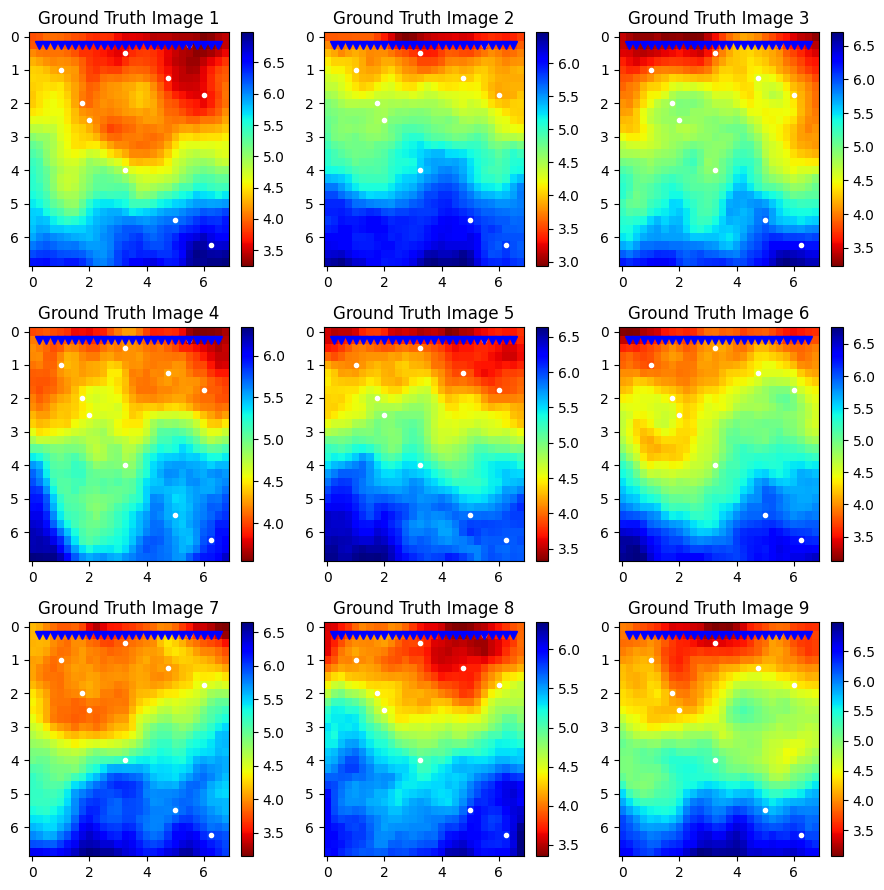

In [166]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9)) 

for i in range(9):
    ax = axes[i // 3, i % 3]  
    
    truth_image = truth_dataset[i, 0, :, :].cpu().numpy()
    
    nx = truth_image.shape[0]
    nz = truth_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
    
    vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r')
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source')
    ax.plot(recx, recz, 'v', color='b', label='receiver')
    ax.invert_yaxis()
    ax.set_title(f"Ground Truth Image {i+1}")
    
plt.tight_layout()
plt.show()

In [79]:
train_dataset = torch.utils.data.TensorDataset(truth_dataset[:train_size], transformed_dataset[:train_size])
validation_dataset = torch.utils.data.TensorDataset(truth_dataset[train_size:(train_size + validation_size)], 
                                                    transformed_dataset[train_size:(train_size + validation_size)])
test_dataset = torch.utils.data.TensorDataset(truth_dataset[(train_size + validation_size):(train_size+validation_size+test_size)]
                                              , transformed_dataset[(train_size + validation_size):(train_size+validation_size+test_size)])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
class UNet(nn.Module):
    def __init__(
        self, 
        in_channels=1, 
        out_channels=1,
        channels_list=(32, 64, 128, 256),
        bottleneck_channels=512,
        min_channels_decoder=64,
        n_groups=8,
    ):
    
        super().__init__()
        ch = in_channels
        
        #encoder
        self.encoder_blocks = nn.ModuleList()
        ch_hidden_list = []
        
        layers = []
        layers.append(nn.ZeroPad2d(2))
        ch_ = channels_list[0]
        layers.append(nn.Conv2d(ch, ch_, 3, padding=1))
        ch = ch_
        self.encoder_blocks.append(nn.Sequential(*layers))
        ch_hidden_list.append(ch)

        for i_level in range(len(channels_list)):
            ch_ = channels_list[i_level]
            downsample = i_level != 0

            layers = []
            if downsample:
                layers.append(nn.MaxPool2d(2))
            layers.append(nn.Conv2d(ch, ch_, 3, padding=1))
            ch = ch_
            layers.append(nn.GroupNorm(n_groups, ch))
            layers.append(nn.LeakyReLU(0.1))
            self.encoder_blocks.append(nn.Sequential(*layers))
            ch_hidden_list.append(ch)

        ## Bottleneck
        ## ==========
        ch_ = bottleneck_channels
        layers = []
        layers.append(nn.Conv2d(ch, ch_, 3, padding=1))
        ch = ch_
        layers.append(nn.GroupNorm(n_groups, ch))
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Conv2d(ch, ch, 3, padding=1))
        layers.append(nn.GroupNorm(n_groups, ch))
        layers.append(nn.LeakyReLU(0.1))
        self.bottleneck = nn.Sequential(*layers)

        ## Decoder
        ## =======
        self.decoder_blocks = nn.ModuleList([])
        for i_level in reversed(range(len(channels_list))):
            ch_ = max(channels_list[i_level], min_channels_decoder)
            downsample = i_level != 0
            ch = ch + ch_hidden_list.pop()
            layers = []

            layers.append(nn.Conv2d(ch, ch_, 3, padding=1))
            ch = ch_
            layers.append(nn.GroupNorm(n_groups, ch))
            layers.append(nn.LeakyReLU(0.1))
            if downsample:
                layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
            self.decoder_blocks.append(nn.Sequential(*layers))

        ch = ch + ch_hidden_list.pop()
        ch_ = channels_list[0]
        layers = []
        layers.append(nn.Conv2d(ch, out_channels, 1))
        layers.append(nn.ZeroPad2d(-2))
        self.decoder_blocks.append(nn.Sequential(*layers))
    
    def forward(self, x):
        h = []
        for block in self.encoder_blocks:
            x = block(x)
            
            h.append(x)

        x = self.bottleneck(x)
        for block in self.decoder_blocks:
            x = torch.cat((x, h.pop()), dim=1)
            x = block(x)
        return x   
    
def gram_schmidt(x):
    x_shape = x.shape
    x = x.flatten(2)

    x_orth = []
    proj_vec_list = []
    for i in range(x.shape[1]):
        w = x[:, i, :]
        for w2 in proj_vec_list:
            w = w - w2 * torch.sum(w * w2, dim=-1, keepdim=True)
        w_hat = w.detach() / w.detach().norm(dim=-1, keepdim=True)

        x_orth.append(w)
        proj_vec_list.append(w_hat)

    x_orth = torch.stack(x_orth, dim=1).view(*x_shape)
    return x_orth

class RestorationWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()

        self.net = net
        self.linear_projection = nn.Linear(10 * 26, 28 * 28)

    def forward(self, x):  
        x = x.float()
        x = x.view(x.size(0), -1)
        x = self.linear_projection(x)
        x = x.view(x.size(0), 1, 28, 28)

        x = (x - 0.5) / 0.2
        x = self.net(x)
        x = (x * 0.2) + 0.5

        return x


class PCWrapper(nn.Module):
    def __init__(self, net, n_dirs):
        super().__init__()

        self.net = net
        self.n_dirs = n_dirs
        
        self.linear_projection = nn.Linear(10 * 26, 28 * 28)

    def forward(self, x_distorted, x_restored): 
        x_distorted = x_distorted.float()
        x_distorted = x_distorted.view(x_distorted.size(0), -1)
        x_distorted = self.linear_projection(x_distorted)
        x_distorted = x_distorted.view(x_distorted.size(0), 1, 28, 28)

        x_restored = x_restored.float()
        x = torch.cat((x_distorted, x_restored), dim=1)

        x = (x - 0.5) / 0.2
        
        # print(x.shape)
        w_mat = self.net(x)
        w_mat = w_mat * 0.2

        w_mat = w_mat.unflatten(1, (self.n_dirs, w_mat.shape[1] // self.n_dirs))
        w_mat = w_mat.flatten(0, 1)
        w_mat = w_mat.unflatten(0, (w_mat.shape[0] // self.n_dirs, self.n_dirs))

        w_mat = gram_schmidt(w_mat)
        return w_mat     
    
restoration_net = RestorationWrapper(UNet()).to(device)
restoration_net.train()
restoration_optimizer = torch.optim.Adam(restoration_net.parameters(), lr=5e-4, betas=(0.9, 0.999))
restoration_step = 0

In [45]:
restoration_checkpt_path = "/home/jgao3/CS163/restoration_model_checkpoints"
nppc_checkpt_path = "/home/jgao3/CS163/nppc_model_checkpoints"

In [46]:
restoration_objective_log = []
validation_loss_log = []
test_loss_log = []
path_to_load = f"{restoration_checkpt_path}/restoration_model_epoch_{140}.pth"
# Load saved model checkpoint if it already exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    restoration_net.load_state_dict(checkpoint['model_state_dict'])
    restoration_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    restoration_step = checkpoint['epoch'] * 273
    restoration_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])
else:
    print("Proceeding to main training loop")
    for x, y in tqdm.tqdm(LoopLoader(train_loader, restoration_n_steps)):
        x_org = y.to(device)
        x_restored = restoration_net(x_org)
        x_truth = x.to(device)
        err = x_truth - x_restored
        objective = err.pow(2).flatten(1).mean()
        restoration_optimizer.zero_grad()
        objective.backward()
        restoration_optimizer.step()
        restoration_step += 1
        if restoration_step % 273 == 0:
            restoration_objective_log.append(objective.detach().item())
            with torch.no_grad():
                total_val_loss = 0
                samples = 0
                restoration_net.eval()
                for x_val, y_val in validation_loader:
                    x_org_val = y_val.to(device)
                    # Perform forward pass for restoration
                    x_restored_val = restoration_net(x_org_val)
                    # Assuming ground truth is in `x_test`
                    x_truth_val = x_val.to(device)
                    # Calculate error (MSE loss)
                    err_val = x_truth_val - x_restored_val
                    objective_val = err_val.pow(2).flatten(1).mean()
                    total_val_loss += objective_val.item() * x_org_val.shape[0]
                    samples += x_org_val.shape[0]
                # Calculate and log the average test loss
                avg_test_loss = total_val_loss / samples
                validation_loss_log.append(avg_test_loss)
                restoration_net.train()
        # Save model every 10 epochs
        if restoration_step % 2730 == 0:
            save_path = f"{restoration_checkpt_path}/restoration_model_epoch_{restoration_step // 273}.pth"
            torch.save({
                'epoch': restoration_step // 273,
                'model_state_dict': restoration_net.state_dict(),
                'optimizer_state_dict': restoration_optimizer.state_dict(),
                'loss': objective.item(),
                'objective_log': restoration_objective_log,
                'validation_log': validation_loss_log
            }, save_path)
            print(f"Model saved at step {restoration_step} to {save_path}")

            with torch.no_grad():
                restoration_net.eval()
                y_org = transformed_dataset[1, :, :, :].to(device)
                x_restored = restoration_net(y_org)
                
                fig, ax = plt.subplots(figsize=(20, 15))
        
                vmin_value = 3.5 
                vmax_value = 6.5
            
                restored_image = x_restored[0, 0, :, :].detach().cpu().numpy()
                
                nx = restored_image.shape[0]
                nz = restored_image.shape[1]
                
                xcoor = np.arange(nx) * dx
                zcoor = np.arange(nz) * dz
                srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
                recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
                
                xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
                vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
                cbar = plt.colorbar(vim, ax=ax) 
                ax.plot(srcx, srcz, '.', color='r', label='source')
                ax.plot(recx, recz, 'v', color='b', label='receiver')
                ax.invert_yaxis()
                ax.set_title(f"Restored Image", fontsize=30)
        
                fig.savefig(f"{restoration_checkpt_path}/restoration_train_img_{restoration_step // 273}.png", dpi=100)
                plt.close(fig)
                restoration_net.train()

Proceeding to main training loop


  7%|▋         | 2726/38220 [00:26<05:13, 113.36it/s]

Model saved at step 2730 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_10.pth


 14%|█▍        | 5454/38220 [00:54<04:49, 113.29it/s]

Model saved at step 5460 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_20.pth


 21%|██▏       | 8185/38220 [01:22<04:24, 113.37it/s]

Model saved at step 8190 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_30.pth


 29%|██▊       | 10917/38220 [01:49<04:00, 113.51it/s]

Model saved at step 10920 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_40.pth


 36%|███▌      | 13652/38220 [02:17<08:48, 46.50it/s] 

Model saved at step 13650 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_50.pth


 43%|████▎     | 16377/38220 [02:44<03:12, 113.30it/s]

Model saved at step 16380 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_60.pth


 50%|████▉     | 19103/38220 [03:12<02:48, 113.39it/s]

Model saved at step 19110 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_70.pth


 57%|█████▋    | 21840/38220 [03:39<05:59, 45.54it/s] 

Model saved at step 21840 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_80.pth


 64%|██████▍   | 24561/38220 [04:06<02:00, 113.34it/s]

Model saved at step 24570 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_90.pth


 71%|███████▏  | 27297/38220 [04:34<01:36, 113.32it/s]

Model saved at step 27300 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_100.pth


 79%|███████▊  | 30032/38220 [05:02<03:22, 40.40it/s] 

Model saved at step 30030 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_110.pth


 86%|████████▌ | 32753/38220 [05:29<00:48, 113.28it/s]

Model saved at step 32760 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_120.pth


 93%|█████████▎| 35489/38220 [05:56<00:24, 113.22it/s]

Model saved at step 35490 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_130.pth


100%|██████████| 38220/38220 [06:24<00:00, 99.44it/s] 

Model saved at step 38220 to /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_140.pth


In [64]:
import plotly.io as pio
import plotly.express as px

fig = px.line(x=np.arange(len(restoration_objective_log)), y=[restoration_objective_log, validation_loss_log], labels={'x': 'Epochs', 'y': 'Loss'})
fig.data[0].name = "Train Loss"
fig.data[1].name = "Validation Loss"
fig.update_layout(
    height=400, 
    width=550,
    yaxis=dict(
        title='Loss'
    ),
    title="Restoration Model"
)

pio.write_html(fig, f'plots/restoration_loss.html')


In [111]:
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * 
                             np.exp(- ((x - (size // 2)) ** 2 + (y - (size // 2)) ** 2) / (2 * sigma ** 2)), (size, size))
    kernel /= np.sum(kernel)
    return kernel

def apply_gaussian_blur(image, kernel):
    height, width = image.shape
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2

    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='edge')
    output_image = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            region = padded_image[i : i + kernel_size, j : j + kernel_size]
            output_image[i, j] = np.sum(region * kernel)

    return output_image

In [112]:
path_to_load = f"{restoration_checkpt_path}/restoration_model_epoch_{110}.pth"
# Load saved model checkpoint if it already exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    restoration_net.load_state_dict(checkpoint['model_state_dict'])
    restoration_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    restoration_step = checkpoint['epoch'] * 273
    restoration_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])

x_org, y_org = next(iter(train_loader))
with torch.no_grad():
    x_restored = restoration_net(y_org.to(device))
x_truth = x_org.to(device)
err = x_truth - x_restored
print("Error for this batch", + (err.pow(2).flatten(1).mean()).item())

batch = 20

# Plot the batch in a single row
fig, axes = plt.subplots(3, batch, figsize=(200, 30))

# Loop through each image in the batch and plot it
for i in range(batch):
    vmin_value = 3.5 
    vmax_value = 6.5

    truth_image = x_org[i, 0, :, :].cpu().numpy()
    
    nx = truth_image.shape[0]
    nz = truth_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    ax = axes[0, i]
    vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
    ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)', fontsize=50)  # Replace with your label for the x-axis
    ax.set_ylabel('Depth (km)', fontsize=50)
    ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
    ax.set_title(f"Ground Truth Image {i+1}", fontsize=50)

# Loop through each image in the batch and plot it
for i in range(batch):
    vmin_value = 3.5 
    vmax_value = 6.5

    truth = x_org[i, 0, :, :].cpu().numpy()
    kernel = gaussian_kernel(5, 3)
    blurred_image = apply_gaussian_blur(truth, kernel)
    
    nx = blurred_image.shape[0]
    nz = blurred_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    ax = axes[1, i]
    vim = ax.pcolormesh(xx, zz, blurred_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
    ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)', fontsize=50)  # Replace with your label for the x-axis
    ax.set_ylabel('Depth (km)', fontsize=50)
    ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
    ax.set_title(f"Gaussian Blurred Image {i+1}", fontsize=50)

# Loop through each image in the batch and plot it
for i in range(batch):
    vmin_value = 3.5 
    vmax_value = 6.5

    restored_image = x_restored[i, 0, :, :].cpu().numpy()
    
    nx = restored_image.shape[0]
    nz = restored_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    ax = axes[2, i]
    vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
    ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)', fontsize=50)  # Replace with your label for the x-axis
    ax.set_ylabel('Depth (km)', fontsize=50)
    ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
    ax.set_title(f"Restored Image {i+1}", fontsize=50)

# Adjust layout
plt.tight_layout()
fig.savefig("plots/restoration_train_imgs.png", dpi=250)


Model checkpoint exists. Loading from /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_110.pth.
Error for this batch 0.034936113061411284


In [113]:
test_loader_2 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_data_iter = iter(test_loader_2)
x_org_1, y_org_1 = next(iter(test_loader))
with torch.no_grad():
    x_restored = restoration_net(y_org_1.to(device))
x_truth = x_org_1.to(device)
err = x_truth - x_restored
print("Error for this batch", + (err.pow(2).flatten(1).mean()).item())

batch = 20

# Plot the batch in a single row
fig, axes = plt.subplots(3, batch, figsize=(200, 30))

# Loop through each image in the batch and plot it
for i in range(batch):
    vmin_value = 3.5 
    vmax_value = 6.5

    truth_image = x_org_1[i, 0, :, :].cpu().numpy()
    
    nx = truth_image.shape[0]
    nz = truth_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    ax = axes[0, i]
    vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
    ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)', fontsize=50)  # Replace with your label for the x-axis
    ax.set_ylabel('Depth (km)', fontsize=50)
    ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
    ax.set_title(f"Ground Truth Image {i+1}", fontsize=50)

for i in range(batch):
    vmin_value = 3.5 
    vmax_value = 6.5

    truth = x_org_1[i, 0, :, :].cpu().numpy()
    kernel = gaussian_kernel(5, 3)
    blurred_image = apply_gaussian_blur(truth, kernel)
    
    nx = blurred_image.shape[0]
    nz = blurred_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    ax = axes[1, i]
    vim = ax.pcolormesh(xx, zz, blurred_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
    ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)', fontsize=50)  # Replace with your label for the x-axis
    ax.set_ylabel('Depth (km)', fontsize=50)
    ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
    ax.set_title(f"Gaussian Blurred Image {i+1}", fontsize=50)

# Loop through each image in the batch and plot it
for i in range(batch):
    vmin_value = 3.5 
    vmax_value = 6.5

    restored_image = x_restored[i, 0, :, :].cpu().numpy()
    
    nx = restored_image.shape[0]
    nz = restored_image.shape[1]
    
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
    recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
    
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    ax = axes[2, i]
    vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
    cbar = plt.colorbar(vim, ax=ax) 
    ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
    ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)', fontsize=50)  # Replace with your label for the x-axis
    ax.set_ylabel('Depth (km)', fontsize=50)
    ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
    ax.set_title(f"Restored Image {i+1}", fontsize=50)

# Adjust layout
plt.tight_layout()
fig.savefig("plots/restoration_test_imgs.png", dpi=250)

Error for this batch 0.03527043030984685


In [95]:
nppc_net = PCWrapper(UNet(in_channels=1 + 1, out_channels=1 * n_dirs), n_dirs=n_dirs).to(device)
nppc_net.train()
nppc_optimizer = torch.optim.Adam(nppc_net.parameters(), lr=1e-5, betas=(0.9, 0.999))
nppc_step = 0 

In [96]:
nppc_objective_log = []
validation_loss_log = []
path_to_load = f"{nppc_checkpt_path}/nppc_model_epoch_{nppc_n_steps // 273}.pth"
#Load saved model checkpoint if it exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    nppc_net.load_state_dict(checkpoint['model_state_dict'])
    nppc_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    nppc_step = checkpoint['epoch'] * 273
    nppc_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])
else:
    print("Proceeding to main NPPC training loop.")
    for x, y in tqdm.tqdm(LoopLoader(train_loader, nppc_n_steps)):
        x_org = y.to(device)
        with torch.no_grad():
            x_restored = restoration_net(x_org)
        x_truth = x.to(device)
        err = x_truth - x_restored
        w_mat = nppc_net(x_org, x_restored)
        w_mat_ = w_mat.flatten(2)
        w_norms = w_mat_.norm(dim=2)
        w_hat_mat = w_mat_ / w_norms[:, :, None].double()
        err = (x_truth - x_restored).flatten(1)
        ## Normalizing by the error's norm
        ## -------------------------------
        err_norm = err.norm(dim=1)
        err = err / err_norm[:, None]
        w_norms = w_norms / err_norm[:, None]
        ## W hat loss
        ## ----------
        err_proj = torch.einsum('bki,bi->bk', w_hat_mat, err)
        reconst_err = 1 - err_proj.pow(2).sum(dim=1)
        ## W norms loss
        ## ------------
        second_moment_mse = (w_norms.pow(2) - err_proj.detach().pow(2)).pow(2)
        second_moment_loss_lambda = -1 + 2 * nppc_step / second_moment_loss_grace
        second_moment_loss_lambda = max(min(second_moment_loss_lambda, 1) ,1e-6)
        second_moment_loss_lambda *= second_moment_loss_lambda
        objective = reconst_err.mean() + second_moment_loss_lambda * second_moment_mse.mean()
        nppc_optimizer.zero_grad()
        objective.backward()
        nppc_optimizer.step()
        nppc_step += 1
        if nppc_step % 273 == 0:
            nppc_objective_log.append(objective.detach().item())
            with torch.no_grad():
                test_val_loss = 0
                samples = 0
                nppc_net.eval()
                for x_val, y_val in validation_loader:
                    x_org_val = y_val.to(device)
                    x_restored_val = restoration_net(x_org_val)
                    x_truth_val = x_val.to(device)
                    err = x_truth_val - x_restored_val
                    w_mat = nppc_net(x_org_val, x_restored_val)
                    w_mat_ = w_mat.flatten(2)
                    w_norms = w_mat_.norm(dim=2)
                    w_hat_mat = w_mat_ / w_norms[:, :, None].double()
                    err = (x_truth_val - x_restored_val).flatten(1)
                    ## Normalizing by the error's norm
                    ## -------------------------------
                    err_norm = err.norm(dim=1)
                    err = err / err_norm[:, None]
                    w_norms = w_norms / err_norm[:, None]
                    ## W hat loss
                    ## ----------
                    err_proj = torch.einsum('bki,bi->bk', w_hat_mat, err)
                    reconst_err = 1 - err_proj.pow(2).sum(dim=1)
                    ## W norms loss
                    ## ------------
                    second_moment_mse = (w_norms.pow(2) - err_proj.detach().pow(2)).pow(2)
                    objective = reconst_err.mean() + second_moment_loss_lambda * second_moment_mse.mean()
                    test_val_loss += objective.item() * x_org_val.shape[0]
                    samples += x_org_val.shape[0]
                        # Average test loss
                avg_test_loss = test_val_loss / samples
                validation_loss_log.append(avg_test_loss)
                nppc_net.train()
        # Save model every 10 epochs
        if nppc_step % 2730 == 0:
            save_path = f"{nppc_checkpt_path}/nppc_model_epoch_{nppc_step // 273}.pth"
            torch.save({
                'epoch': nppc_step // 273,
                'model_state_dict': nppc_net.state_dict(),
                'optimizer_state_dict': nppc_optimizer.state_dict(),
                'loss': objective.item(),
                'objective_log': nppc_objective_log,
                'validation_log': validation_loss_log
            }, save_path)
            print(f"Model saved at step {nppc_step} to {save_path}")

Model checkpoint exists. Loading from /home/jgao3/CS163/nppc_model_checkpoints/nppc_model_epoch_100.pth.


In [97]:
import plotly.io as pio
import plotly.express as px


fig = px.line(x=np.arange(len(nppc_objective_log)), y=[nppc_objective_log, validation_loss_log], labels={'x': 'Epochs', 'y': 'Loss'})
fig.data[0].name = "Train Loss"
fig.data[1].name = "Validation Loss"
fig.update_layout(
    height=400, 
    width=550,
    yaxis=dict(
        type='log',
        title='Loss'
    ),
    title="NPPC Model"
)

pio.write_html(fig, f'plots/nppc_loss.html')


In [98]:
path_to_load = f"{restoration_checkpt_path}/restoration_model_epoch_{110}.pth"
# Load saved model checkpoint if it already exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    restoration_net.load_state_dict(checkpoint['model_state_dict'])
    restoration_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    restoration_step = checkpoint['epoch'] * 273
    restoration_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])

path_to_load = f"{nppc_checkpt_path}/nppc_model_epoch_{20}.pth"
# Load saved model checkpoint if it exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    nppc_net.load_state_dict(checkpoint['model_state_dict'])
    nppc_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    nppc_step = checkpoint['epoch'] * 273
    nppc_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])

Model checkpoint exists. Loading from /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_110.pth.
Model checkpoint exists. Loading from /home/jgao3/CS163/nppc_model_checkpoints/nppc_model_epoch_20.pth.


Error for this batch 0.03313533124438817


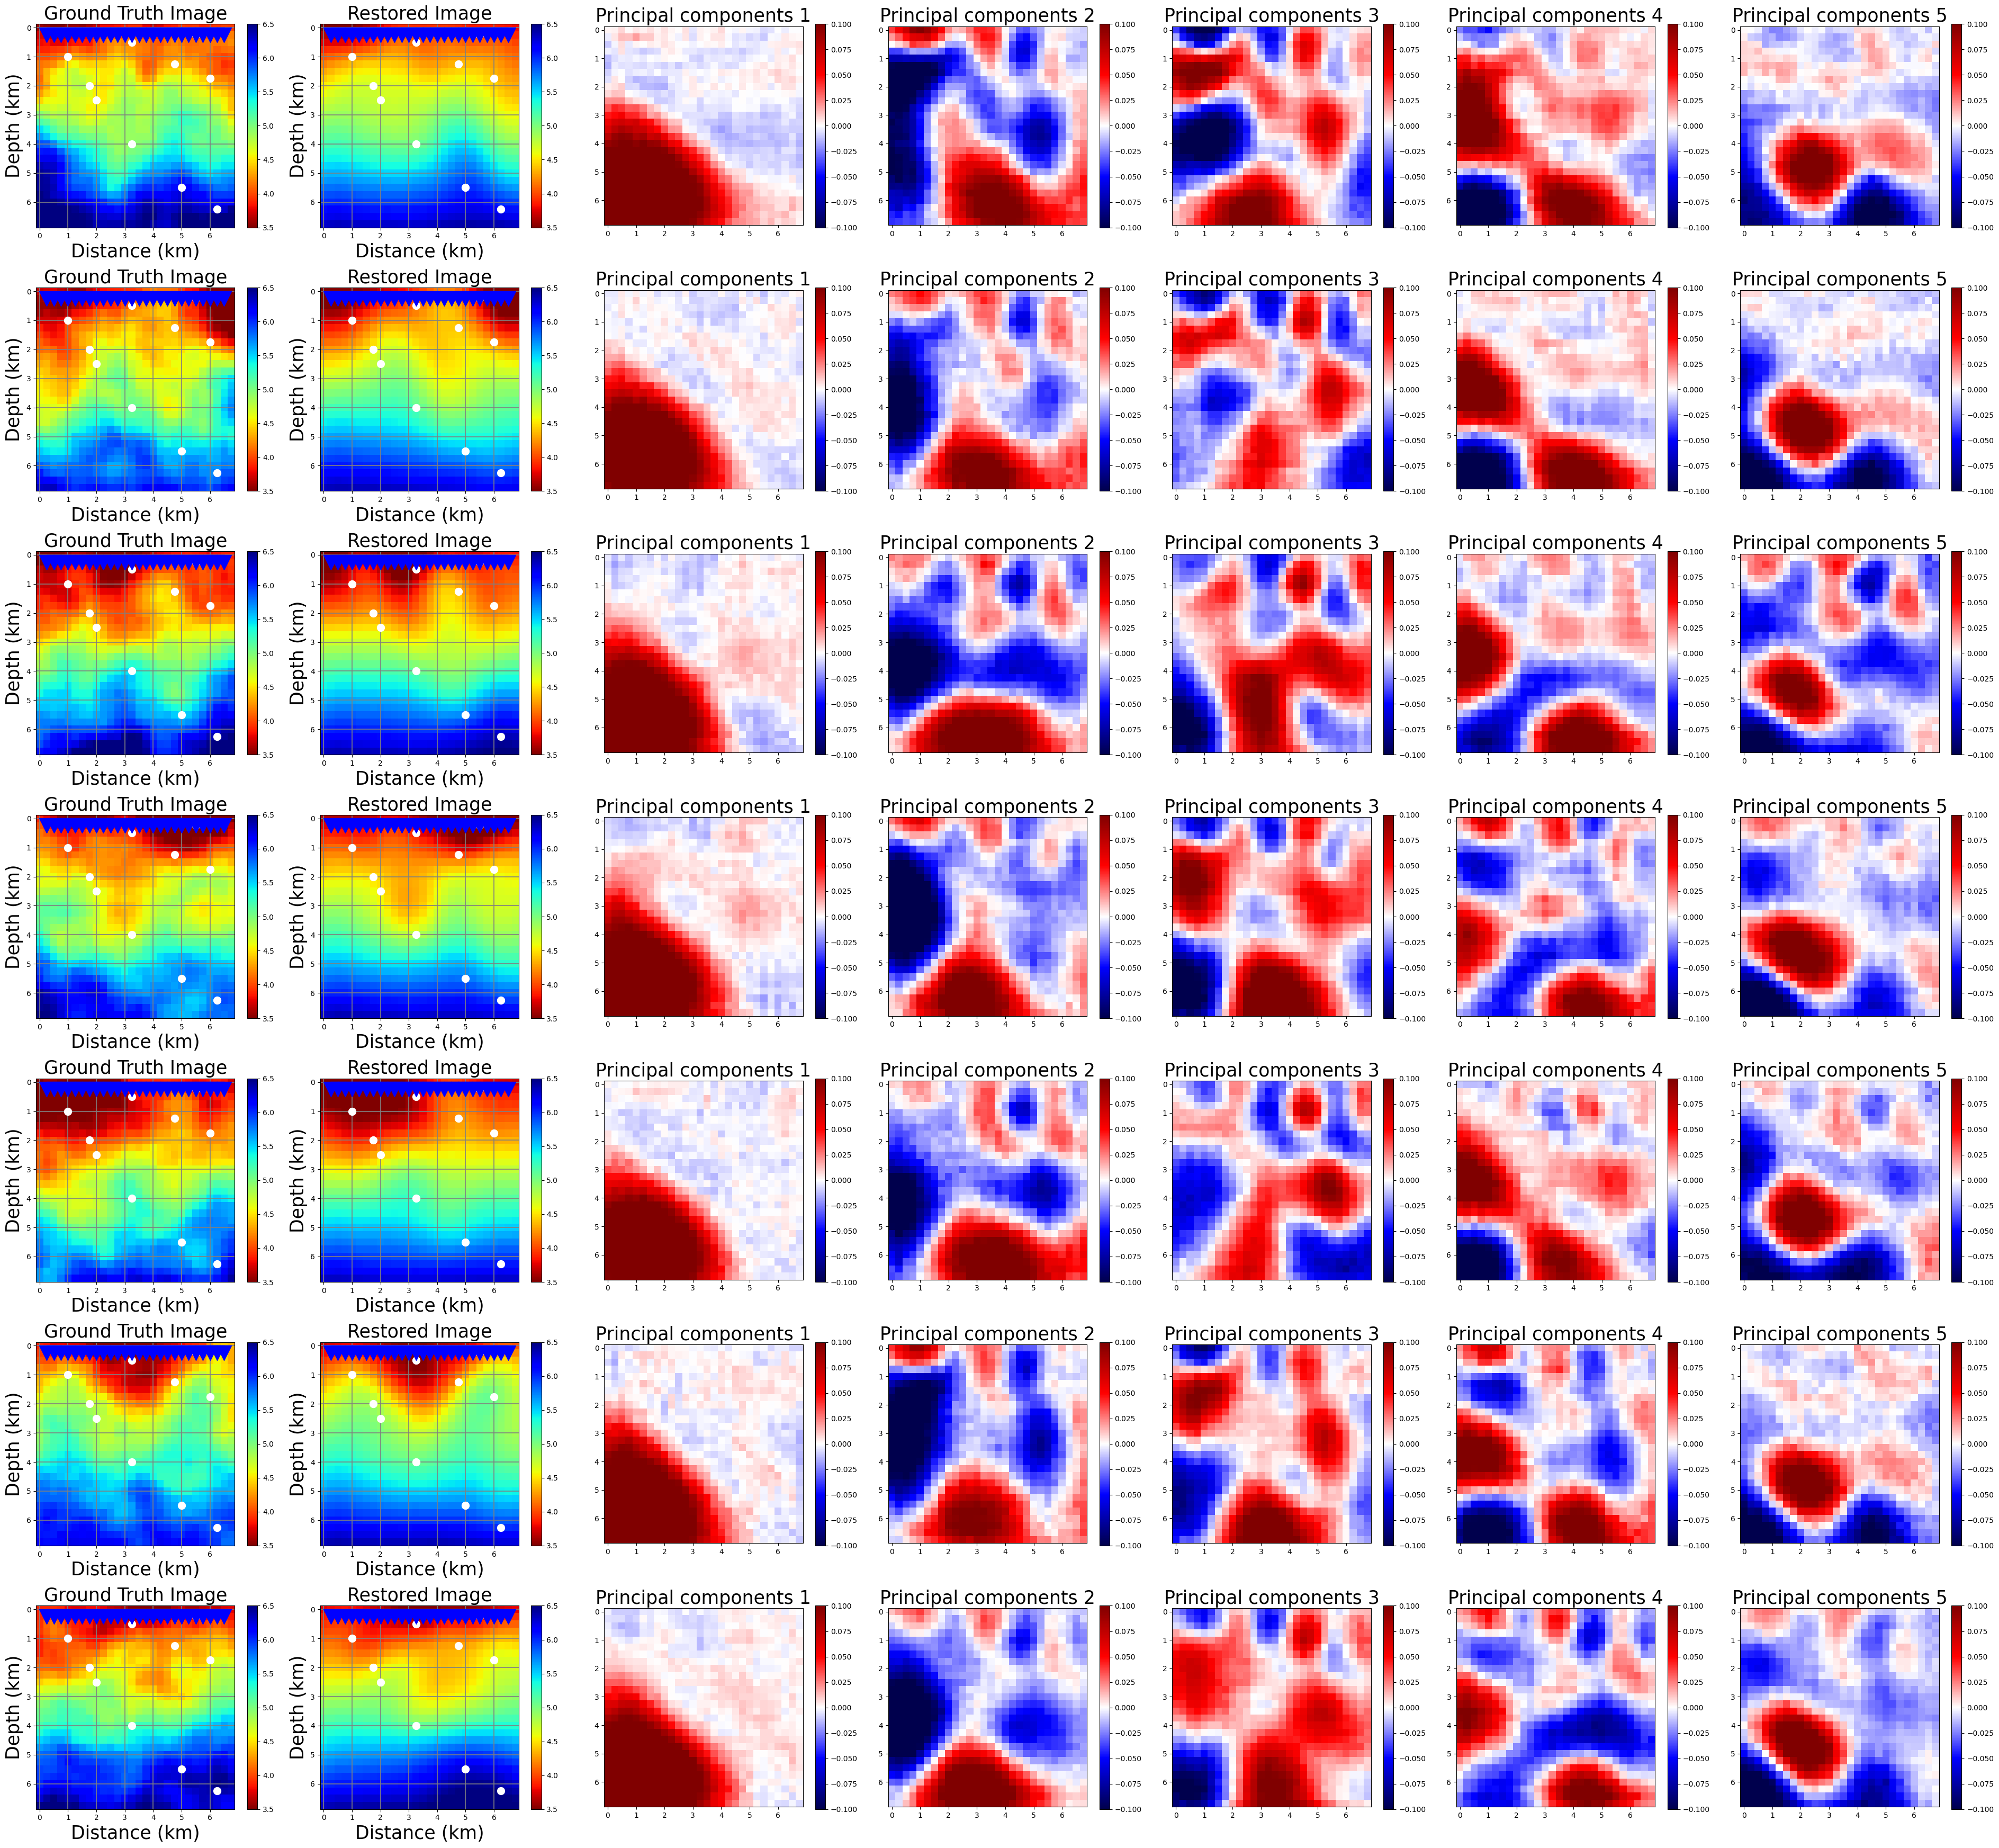

In [108]:
x_org_1, y_org_1 = next(iter(train_loader))
with torch.no_grad():
    x_restored = restoration_net(y_org_1.to(device))
    w_mat = nppc_net(y_org_1.to(device), x_restored.to(device))
x_truth = x_org_1.to(device)
err = x_truth - x_restored
print("Error for this batch", + (err.pow(2).flatten(1).mean()).item())

fig, axes = plt.subplots(7, 7, figsize=(38, 35))

for i in range(7):
    for j in range(7):
        ax = axes[i, j]  # Select the current subplot

        # Select the specific image for this subplot
        if j == 0:  # For the first column, use the same image (first image)
            truth_image = x_truth[i, 0, :, :].cpu().numpy()

            nx = restored_image.shape[0]
            nz = restored_image.shape[1]
            
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
            recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
            
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
            vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r', vmin=3.5, vmax=6.5)
            cbar = plt.colorbar(vim, ax=ax) 
            ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
            ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
            ax.invert_yaxis()
            ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
            ax.set_ylabel('Depth (km)', fontsize=25)
            ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
            ax.set_title(f"Ground Truth Image", fontsize=25)
        elif j == 1:  # For the first column, use the same image (first image)
            restored_image = x_restored[i, 0, :, :].cpu().numpy()

            nx = restored_image.shape[0]
            nz = restored_image.shape[1]
            
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
            recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
            
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
            vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=3.5, vmax=6.5)
            cbar = plt.colorbar(vim, ax=ax) 
            ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
            ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
            ax.invert_yaxis()
            ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
            ax.set_ylabel('Depth (km)', fontsize=25)
            ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
            ax.set_title(f"Restored Image", fontsize=25)
        else:  # For the rest of the columns, use a different image 
            wmat_image =  w_mat[i, j-2, 0, :, :].detach().cpu().numpy()
            nx, nz = wmat_image.shape
        
            cmap = plt.get_cmap('RdBu_r')
            ax.set_aspect(1)
            
            # Plot on the first axis (ax1)
            cmap = plt.get_cmap('RdBu_r')
            vim1 = ax.pcolormesh(xx, zz, wmat_image, cmap='seismic', vmin=-0.1, vmax=0.1)
            cbar1 = plt.colorbar(vim1, ax=ax)
            
            ax.invert_yaxis() 
            ax.set_title(f"Principal components {j-1}", fontsize=25)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()
fig.savefig("plots/nppc_train_epoch_20", dpi=150)

Error for this batch 0.03480058612866211


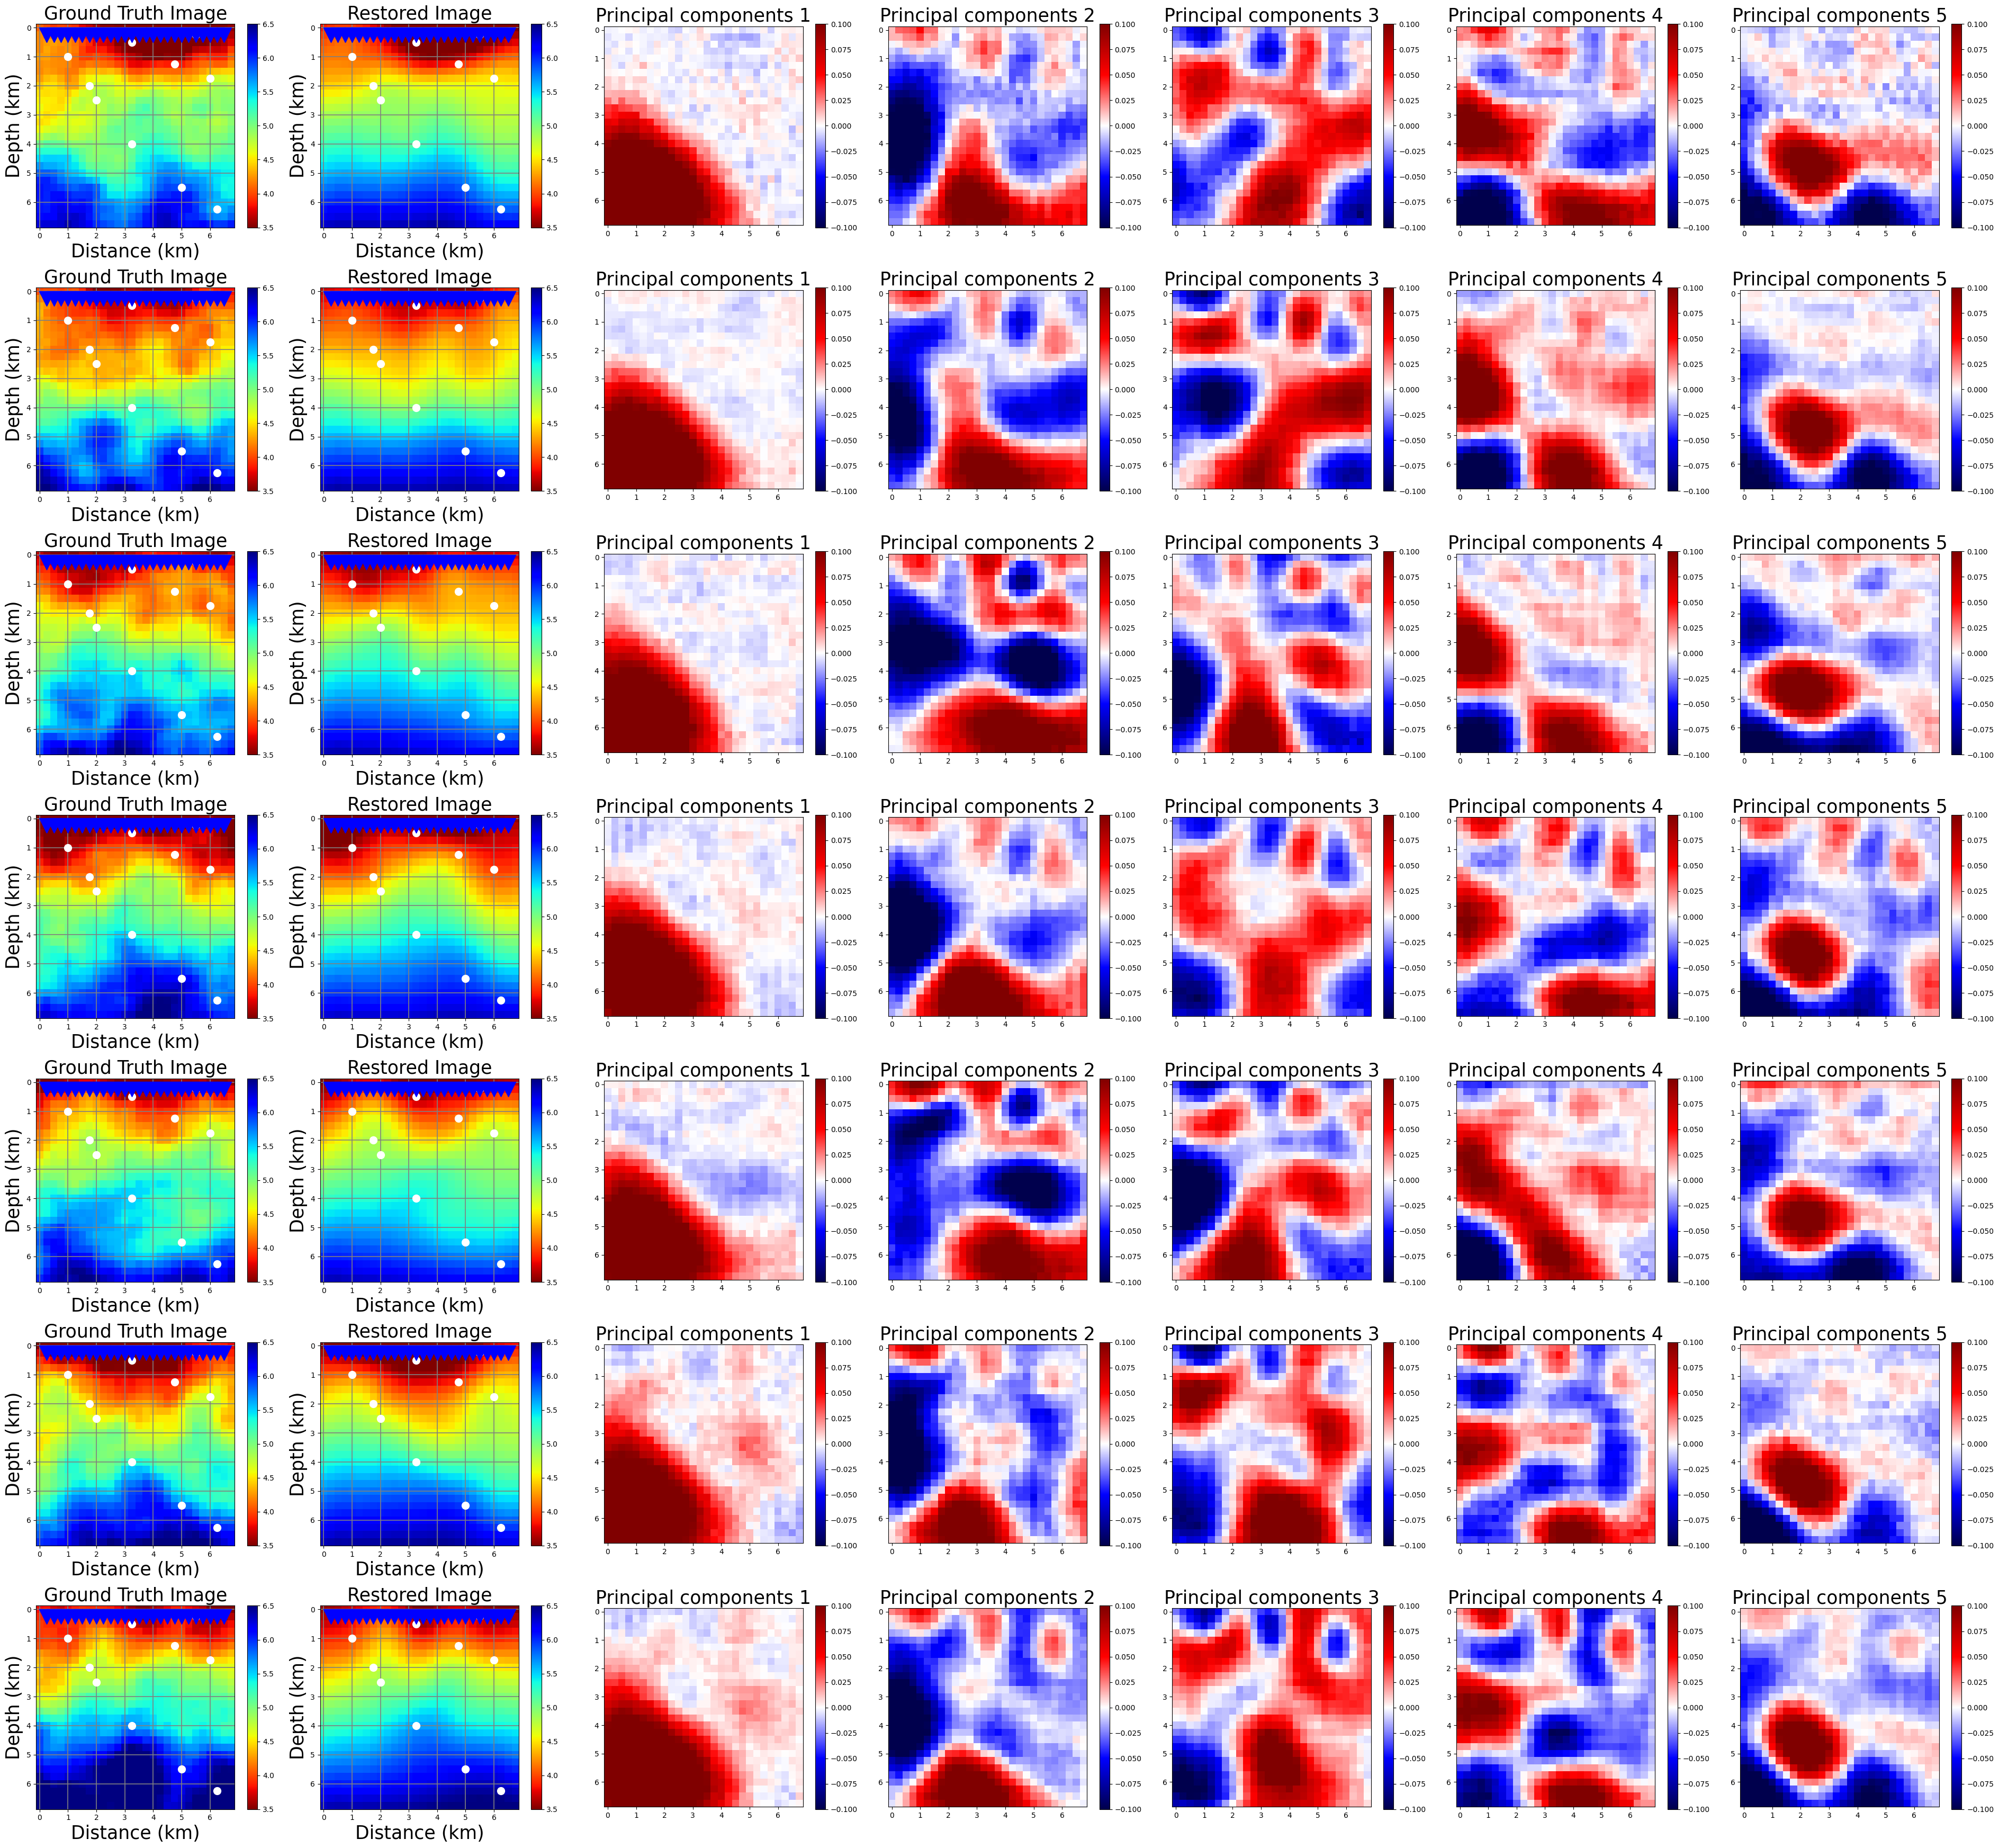

In [114]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
x_org, y_org = next(iter(test_loader))
with torch.no_grad():
    x_restored = restoration_net(y_org.to(device))
    w_mat = nppc_net(y_org.to(device), x_restored.to(device))
x_truth = x_org.to(device)
err = x_truth - x_restored
print("Error for this batch", + (err.pow(2).flatten(1).mean()).item())

fig, axes = plt.subplots(7, 7, figsize=(38, 35))

for i in range(7):
    for j in range(7):
        ax = axes[i, j]  # Select the current subplot

        # Select the specific image for this subplot
        if j == 0:  # For the first column, use the same image (first image)
            truth_image = x_truth[i, 0, :, :].cpu().numpy()

            nx = restored_image.shape[0]
            nz = restored_image.shape[1]
            
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
            recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
            
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
            vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r', vmin=3.5, vmax=6.5)
            cbar = plt.colorbar(vim, ax=ax) 
            ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
            ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
            ax.invert_yaxis()
            ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
            ax.set_ylabel('Depth (km)', fontsize=25)
            ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
            ax.set_title(f"Ground Truth Image", fontsize=25)
        elif j == 1:  # For the first column, use the same image (first image)
            restored_image = x_restored[i, 0, :, :].cpu().numpy()

            nx = restored_image.shape[0]
            nz = restored_image.shape[1]
            
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
            recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
            
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
            vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=3.5, vmax=6.5)
            cbar = plt.colorbar(vim, ax=ax) 
            ax.plot(srcx, srcz, '.', color='w', label='source', markersize=20)
            ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=20)
            ax.invert_yaxis()
            ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
            ax.set_ylabel('Depth (km)', fontsize=25)
            ax.grid(color='gray', linestyle='-', linewidth=1.2, alpha=1)
            ax.set_title(f"Restored Image", fontsize=25)
        else:  # For the rest of the columns, use a different image 
            wmat_image =  w_mat[i, j-2, 0, :, :].detach().cpu().numpy()
            nx, nz = wmat_image.shape
        
            cmap = plt.get_cmap('RdBu_r')
            ax.set_aspect(1)
            
            # Plot on the first axis (ax1)
            cmap = plt.get_cmap('RdBu_r')
            vim1 = ax.pcolormesh(xx, zz, wmat_image, cmap='seismic', vmin=-0.1, vmax=0.1)
            cbar1 = plt.colorbar(vim1, ax=ax)
            
            ax.invert_yaxis() 
            ax.set_title(f"Principal components {j-1}", fontsize=25)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()
fig.savefig("plots/nppc_test_epoch_20", dpi=150)

In [115]:
path_to_load = f"{restoration_checkpt_path}/restoration_model_epoch_{110}.pth"
# Load saved model checkpoint if it already exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    restoration_net.load_state_dict(checkpoint['model_state_dict'])
    restoration_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    restoration_step = checkpoint['epoch'] * 273
    restoration_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])

path_to_load = f"{nppc_checkpt_path}/nppc_model_epoch_{20}.pth"
# Load saved model checkpoint if it exists, else run the standard training loop
if os.path.exists(path_to_load):
    print(f"Model checkpoint exists. Loading from {path_to_load}.")
    # Setting weights_only to True to avoid FutureWarning
    checkpoint = torch.load(path_to_load, weights_only=True)
    nppc_net.load_state_dict(checkpoint['model_state_dict'])
    nppc_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    nppc_step = checkpoint['epoch'] * 273
    nppc_objective_log = checkpoint.get('objective_log', [])
    validation_loss_log = checkpoint.get('validation_log', [])

Model checkpoint exists. Loading from /home/jgao3/CS163/restoration_model_checkpoints/restoration_model_epoch_110.pth.
Model checkpoint exists. Loading from /home/jgao3/CS163/nppc_model_checkpoints/nppc_model_epoch_20.pth.


Error for this batch 0.0350265820819916


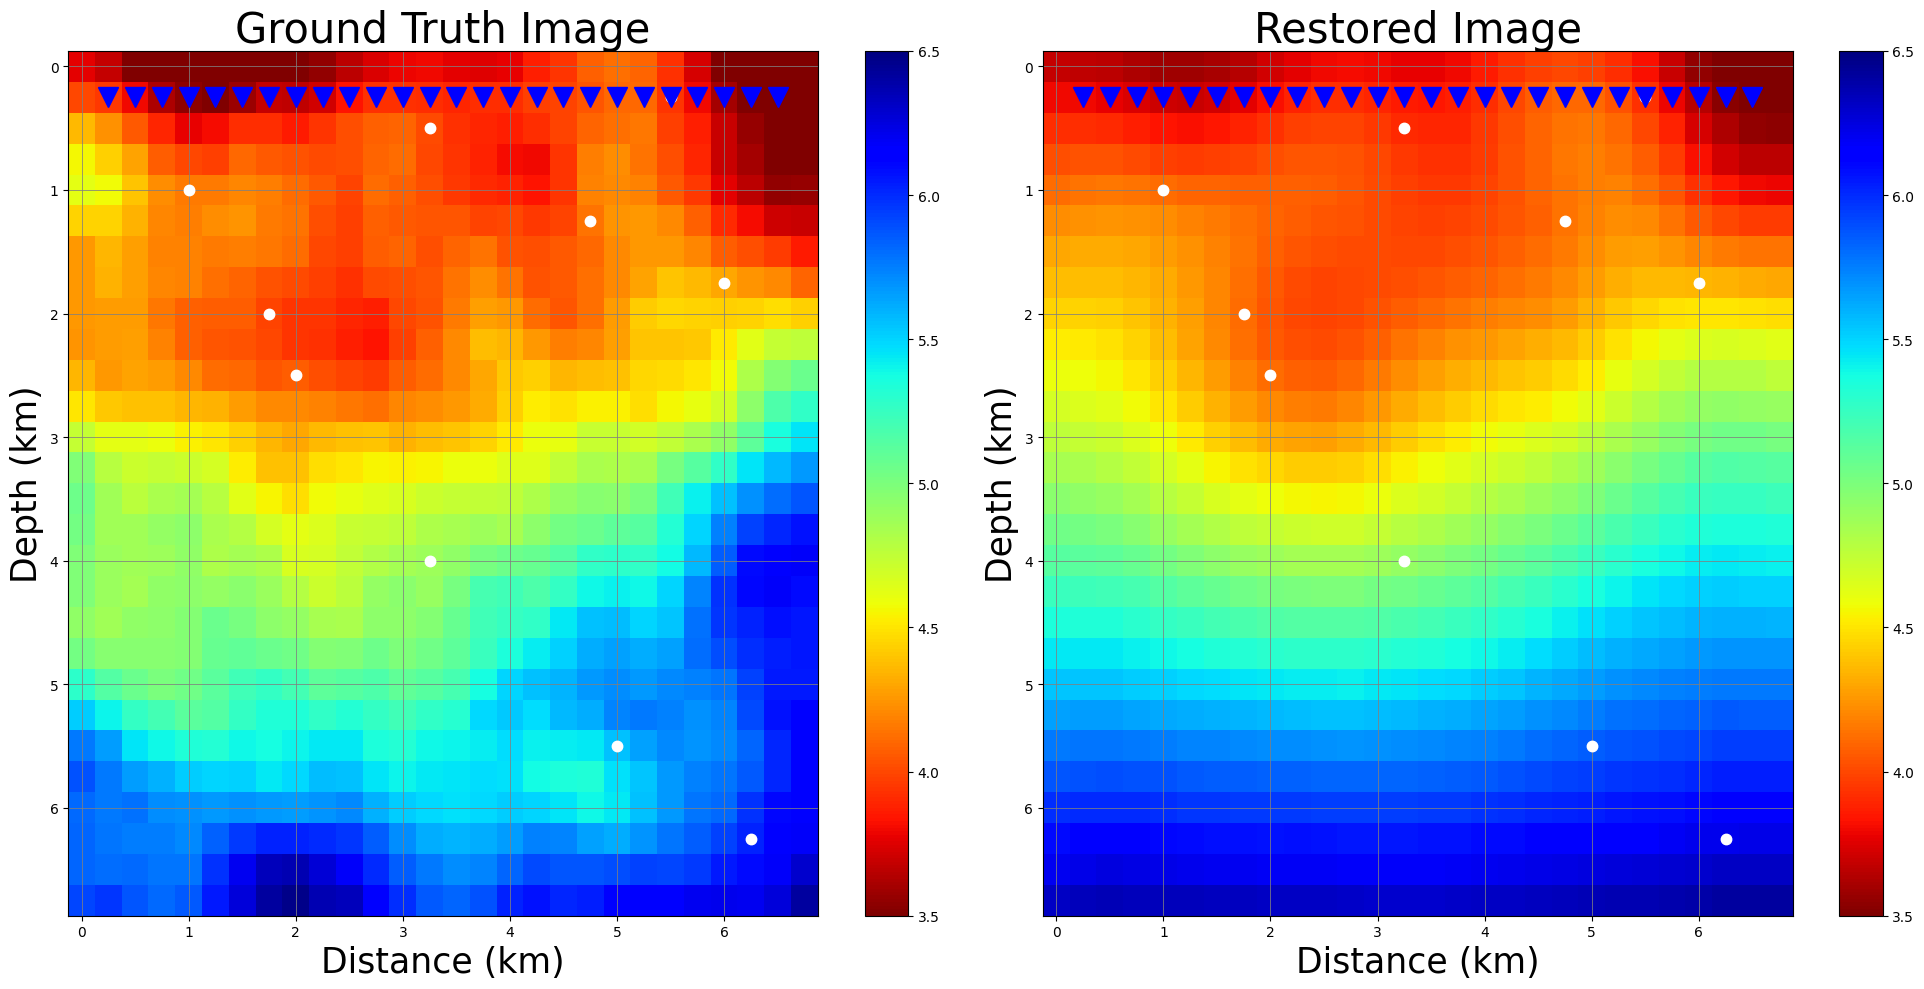

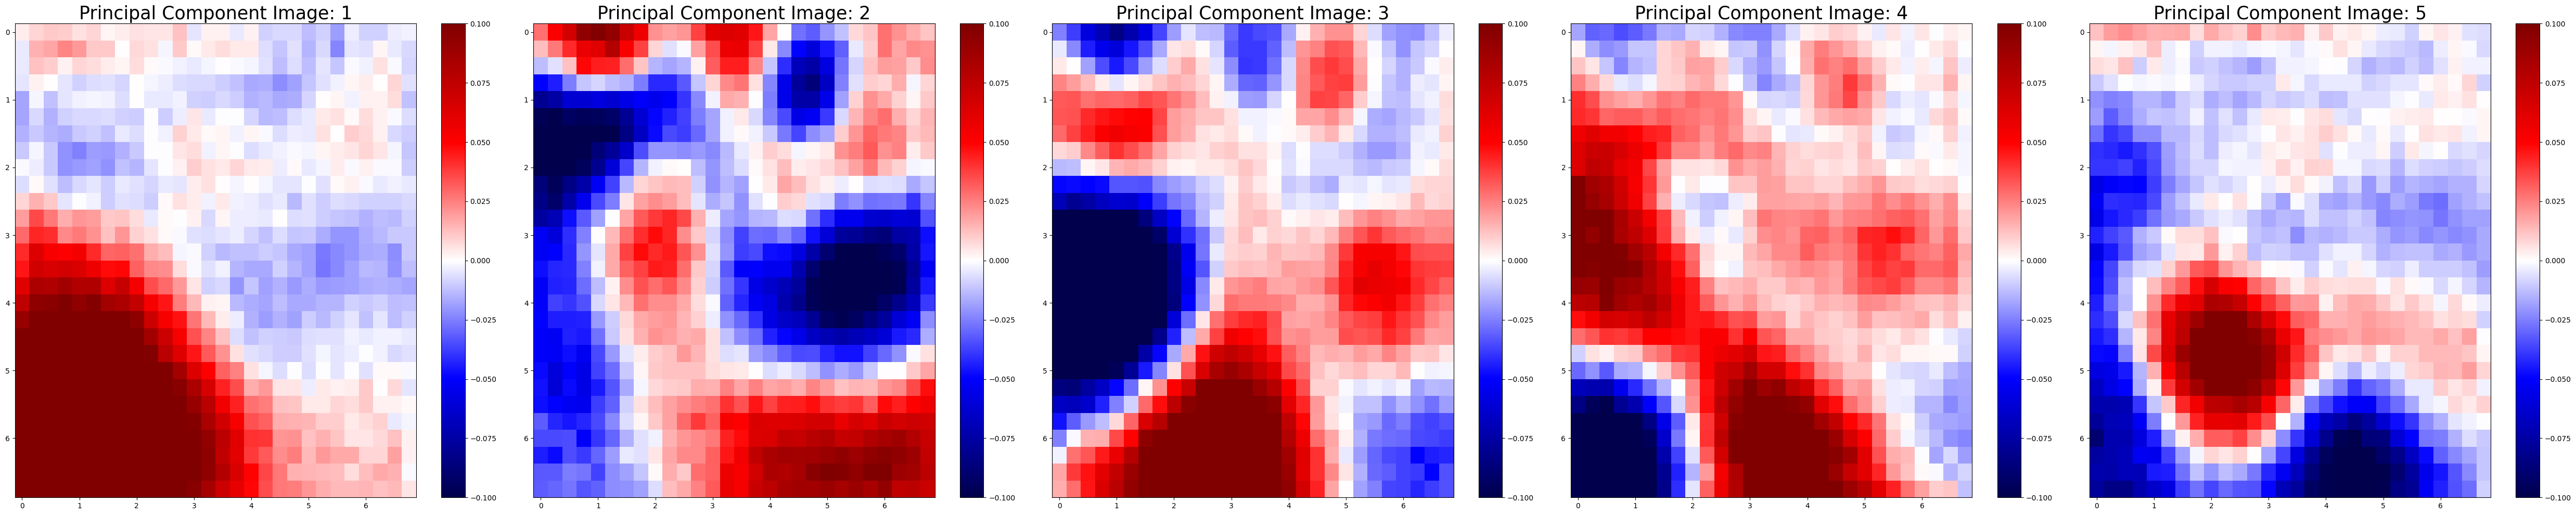

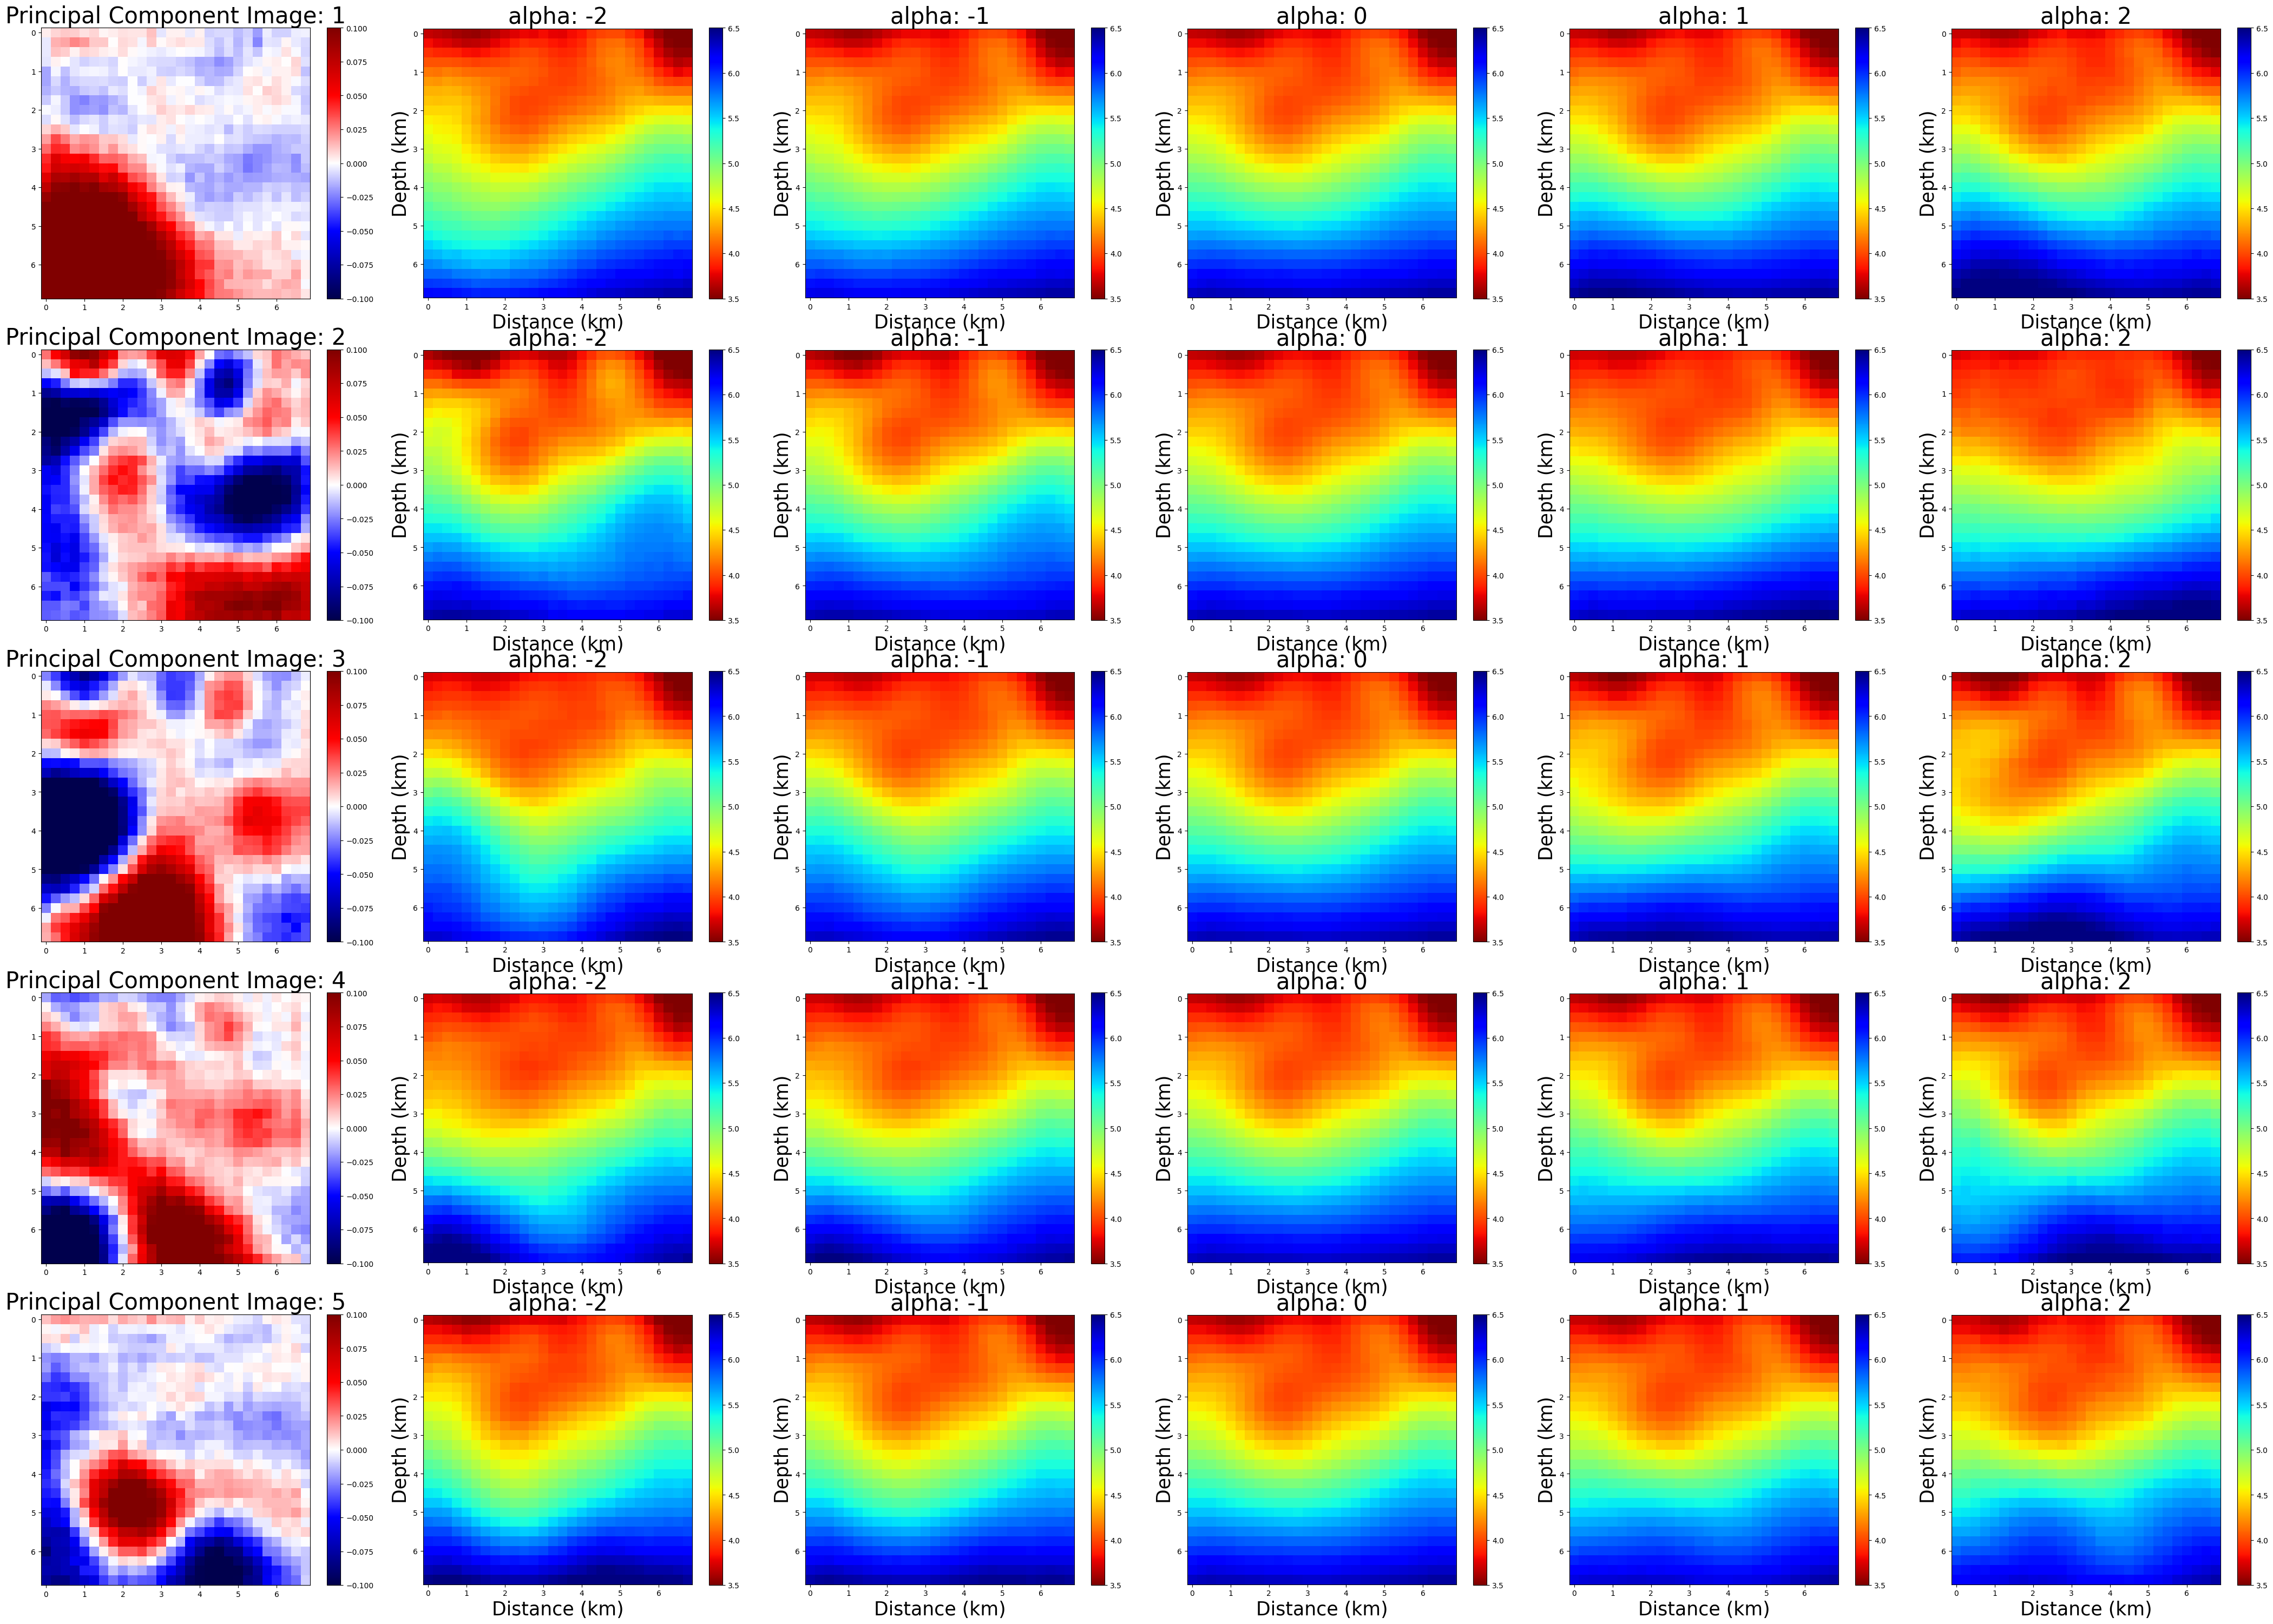

In [162]:
x_org, y_org = next(iter(train_loader))
with torch.no_grad():
    x_restored = restoration_net(y_org.to(device))
    w_mat = nppc_net(y_org.to(device), x_restored.to(device))
x_truth = x_org.to(device)
err = x_truth - x_restored
print("Error for this batch", + (err.pow(2).flatten(1).mean()).item())

batch = 20

# Plot the batch in a single row
fig, axes = plt.subplots(1, 2, figsize=(20, 10))


vmin_value = 3.5 
vmax_value = 6.5
truth_image = x_org[9, 0, :, :].cpu().numpy()

nx = truth_image.shape[0]
nz = truth_image.shape[1]

xcoor = np.arange(nx) * dx
zcoor = np.arange(nz) * dz
srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]

xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

ax = axes[0]
vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
cbar = plt.colorbar(vim, ax=ax) 
ax.plot(srcx, srcz, '.', color='w', label='source', markersize=15)
ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=15)
ax.invert_yaxis()
ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
ax.set_ylabel('Depth (km)', fontsize=25)
ax.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.8)
ax.set_title(f"Ground Truth Image", fontsize=30)

restored_image = x_restored[9, 0, :, :].cpu().numpy()

nx = restored_image.shape[0]
nz = restored_image.shape[1]

xcoor = np.arange(nx) * dx
zcoor = np.arange(nz) * dz
srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]

xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

ax = axes[1]
vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
cbar = plt.colorbar(vim, ax=ax) 
ax.plot(srcx, srcz, '.', color='w', label='source', markersize=15)
ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=15)
ax.invert_yaxis()
ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
ax.set_ylabel('Depth (km)', fontsize=25)
ax.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.8)
ax.set_title(f"Restored Image", fontsize=30)

# Adjust layout
plt.tight_layout()

fig, axes = plt.subplots(1, 5, figsize=(50, 10))

for i in range(5):
    ax = axes[i]

    w_image = w_mat[9, i, 0, :, :].detach().cpu().numpy()
    nx, nz = w_image.shape

    # Generate coordinates
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    # Plot the image using pcolormesh
    vim = ax.pcolormesh(xx, zz, w_image, cmap='seismic', vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(vim, ax=ax)
    ax.invert_yaxis()  # Invert the y-axis to match typical image coordinates
    ax.set_title(f"Principal Component Image: {i + 1}", fontsize=25)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(5, 6, figsize=(42, 30))

for i in range(5):
    for j in range(6):
        ax = axes[i, j]  # Select the current subplot

        # Select the specific image for this subplot
        if j == 0:  # For the first column, use the same image (first image)
            w_image = w_mat[9, i, 0, :, :].detach().cpu().numpy()  # First image of the batch
            nx, nz = w_image.shape

            # Generate coordinates
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
    
            # Plot the image using pcolormesh
            vim = ax.pcolormesh(xx, zz, w_image, cmap='seismic', vmin=-0.1, vmax=0.1)
            cbar = plt.colorbar(vim, ax=ax)
            ax.invert_yaxis()  # Invert the y-axis to match typical image coordinates
            ax.set_title(f"Principal Component Image: {i + 1}", fontsize=30)
        else:  # For the rest of the columns, use a different image  
            alpha = [-2, -1, 0, 1, 2]
            uncertainty_image =  x_restored[9, 0, :, :].cpu().numpy() + alpha[j-1] * w_mat[9, i, 0, :, :].detach().cpu().numpy()
            nx, nz = uncertainty_image.shape
            
            vmin_value = 3.5
            vmax_value = 6.5
        
            cmap = plt.get_cmap('RdBu_r')
            ax.set_aspect(1)
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
            recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
            # Plot on the first axis (ax1)
            cmap = plt.get_cmap('RdBu_r')
            vim1 = ax.pcolormesh(xx, zz, uncertainty_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
            cbar1 = plt.colorbar(vim1, ax=ax)
            
            ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
            ax.set_ylabel('Depth (km)', fontsize=25)
            ax.invert_yaxis() 
            ax.set_title("alpha: " + str(alpha[j-1]), fontsize=30)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()
fig.savefig("plots/nppc_train_uncertainty_30", dpi=150)

Error for this batch 0.03530028136619969


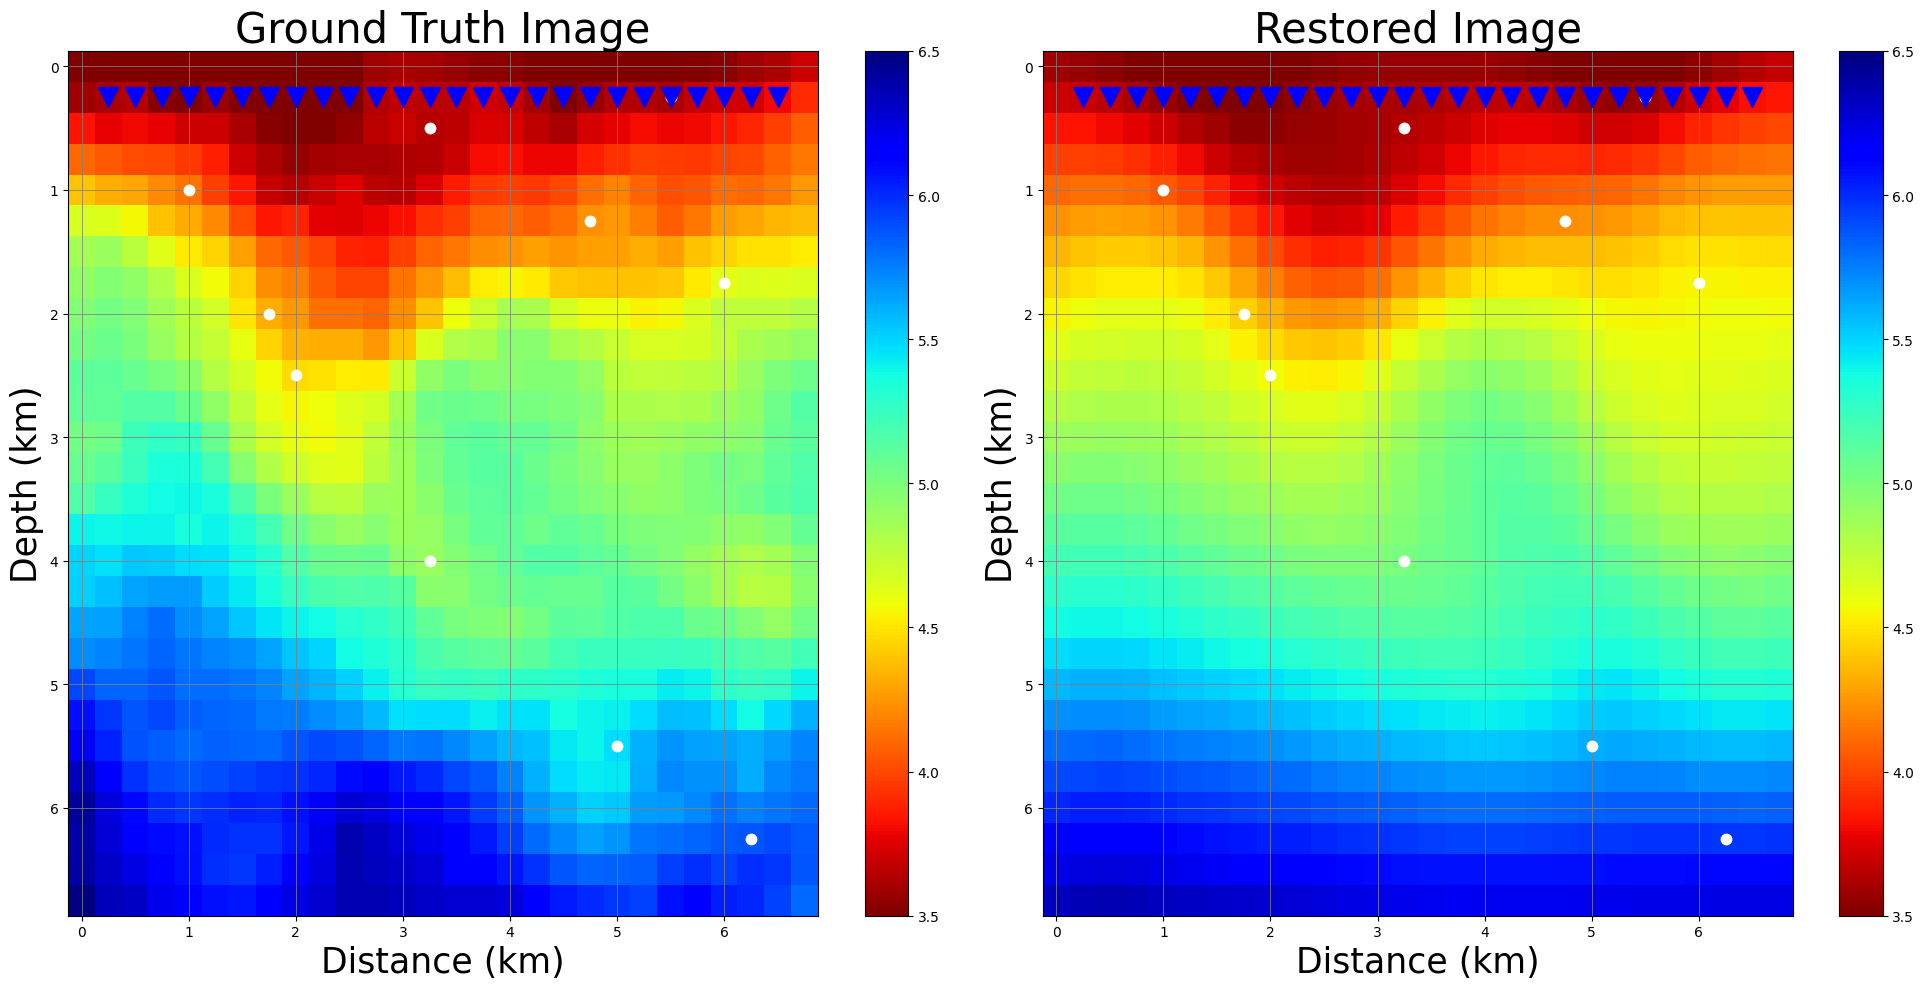

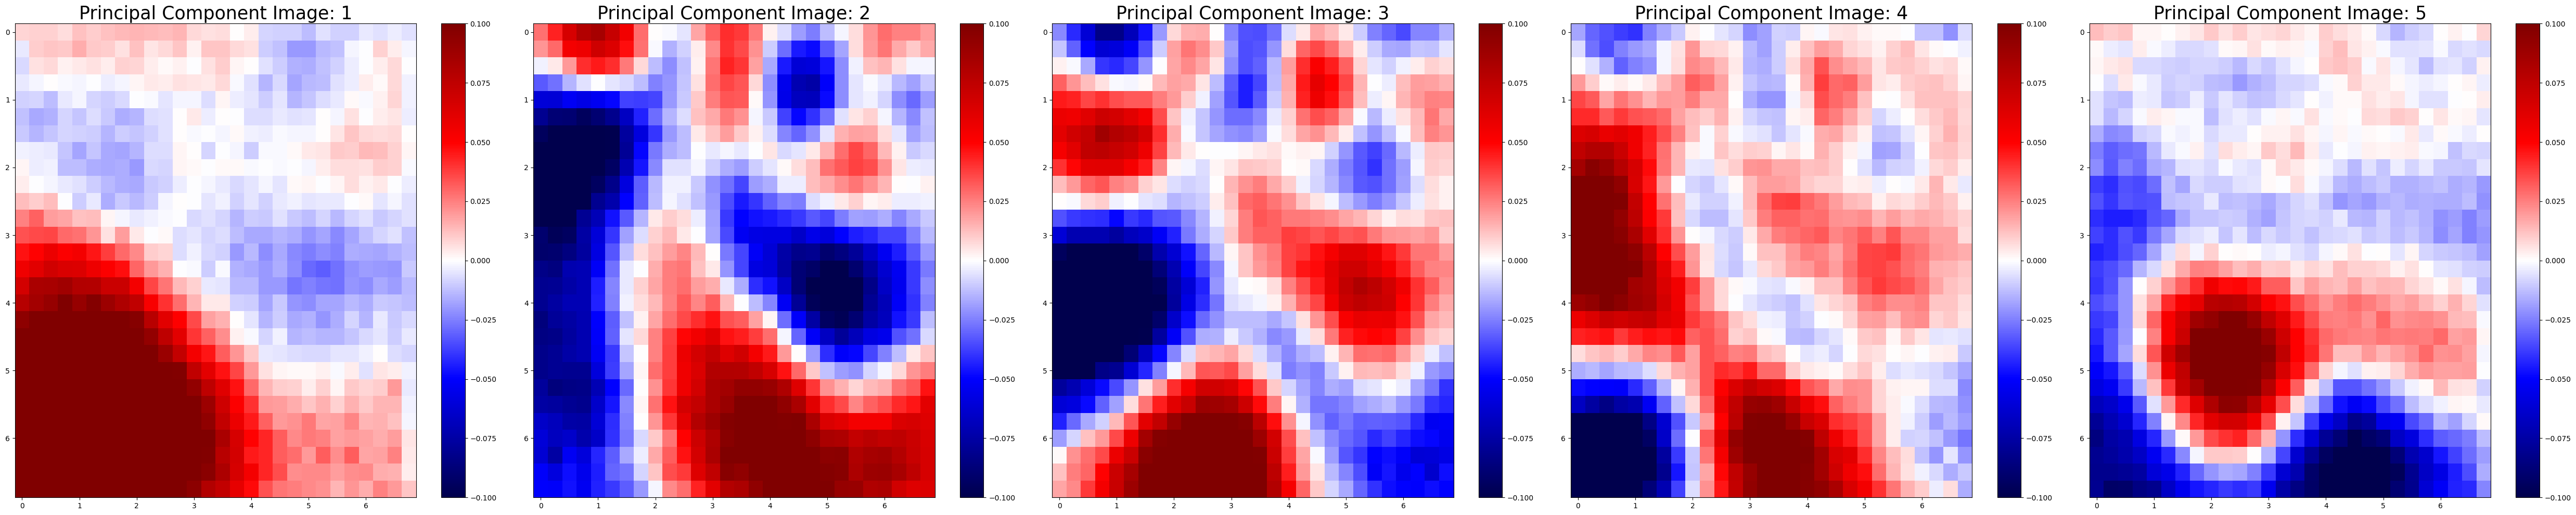

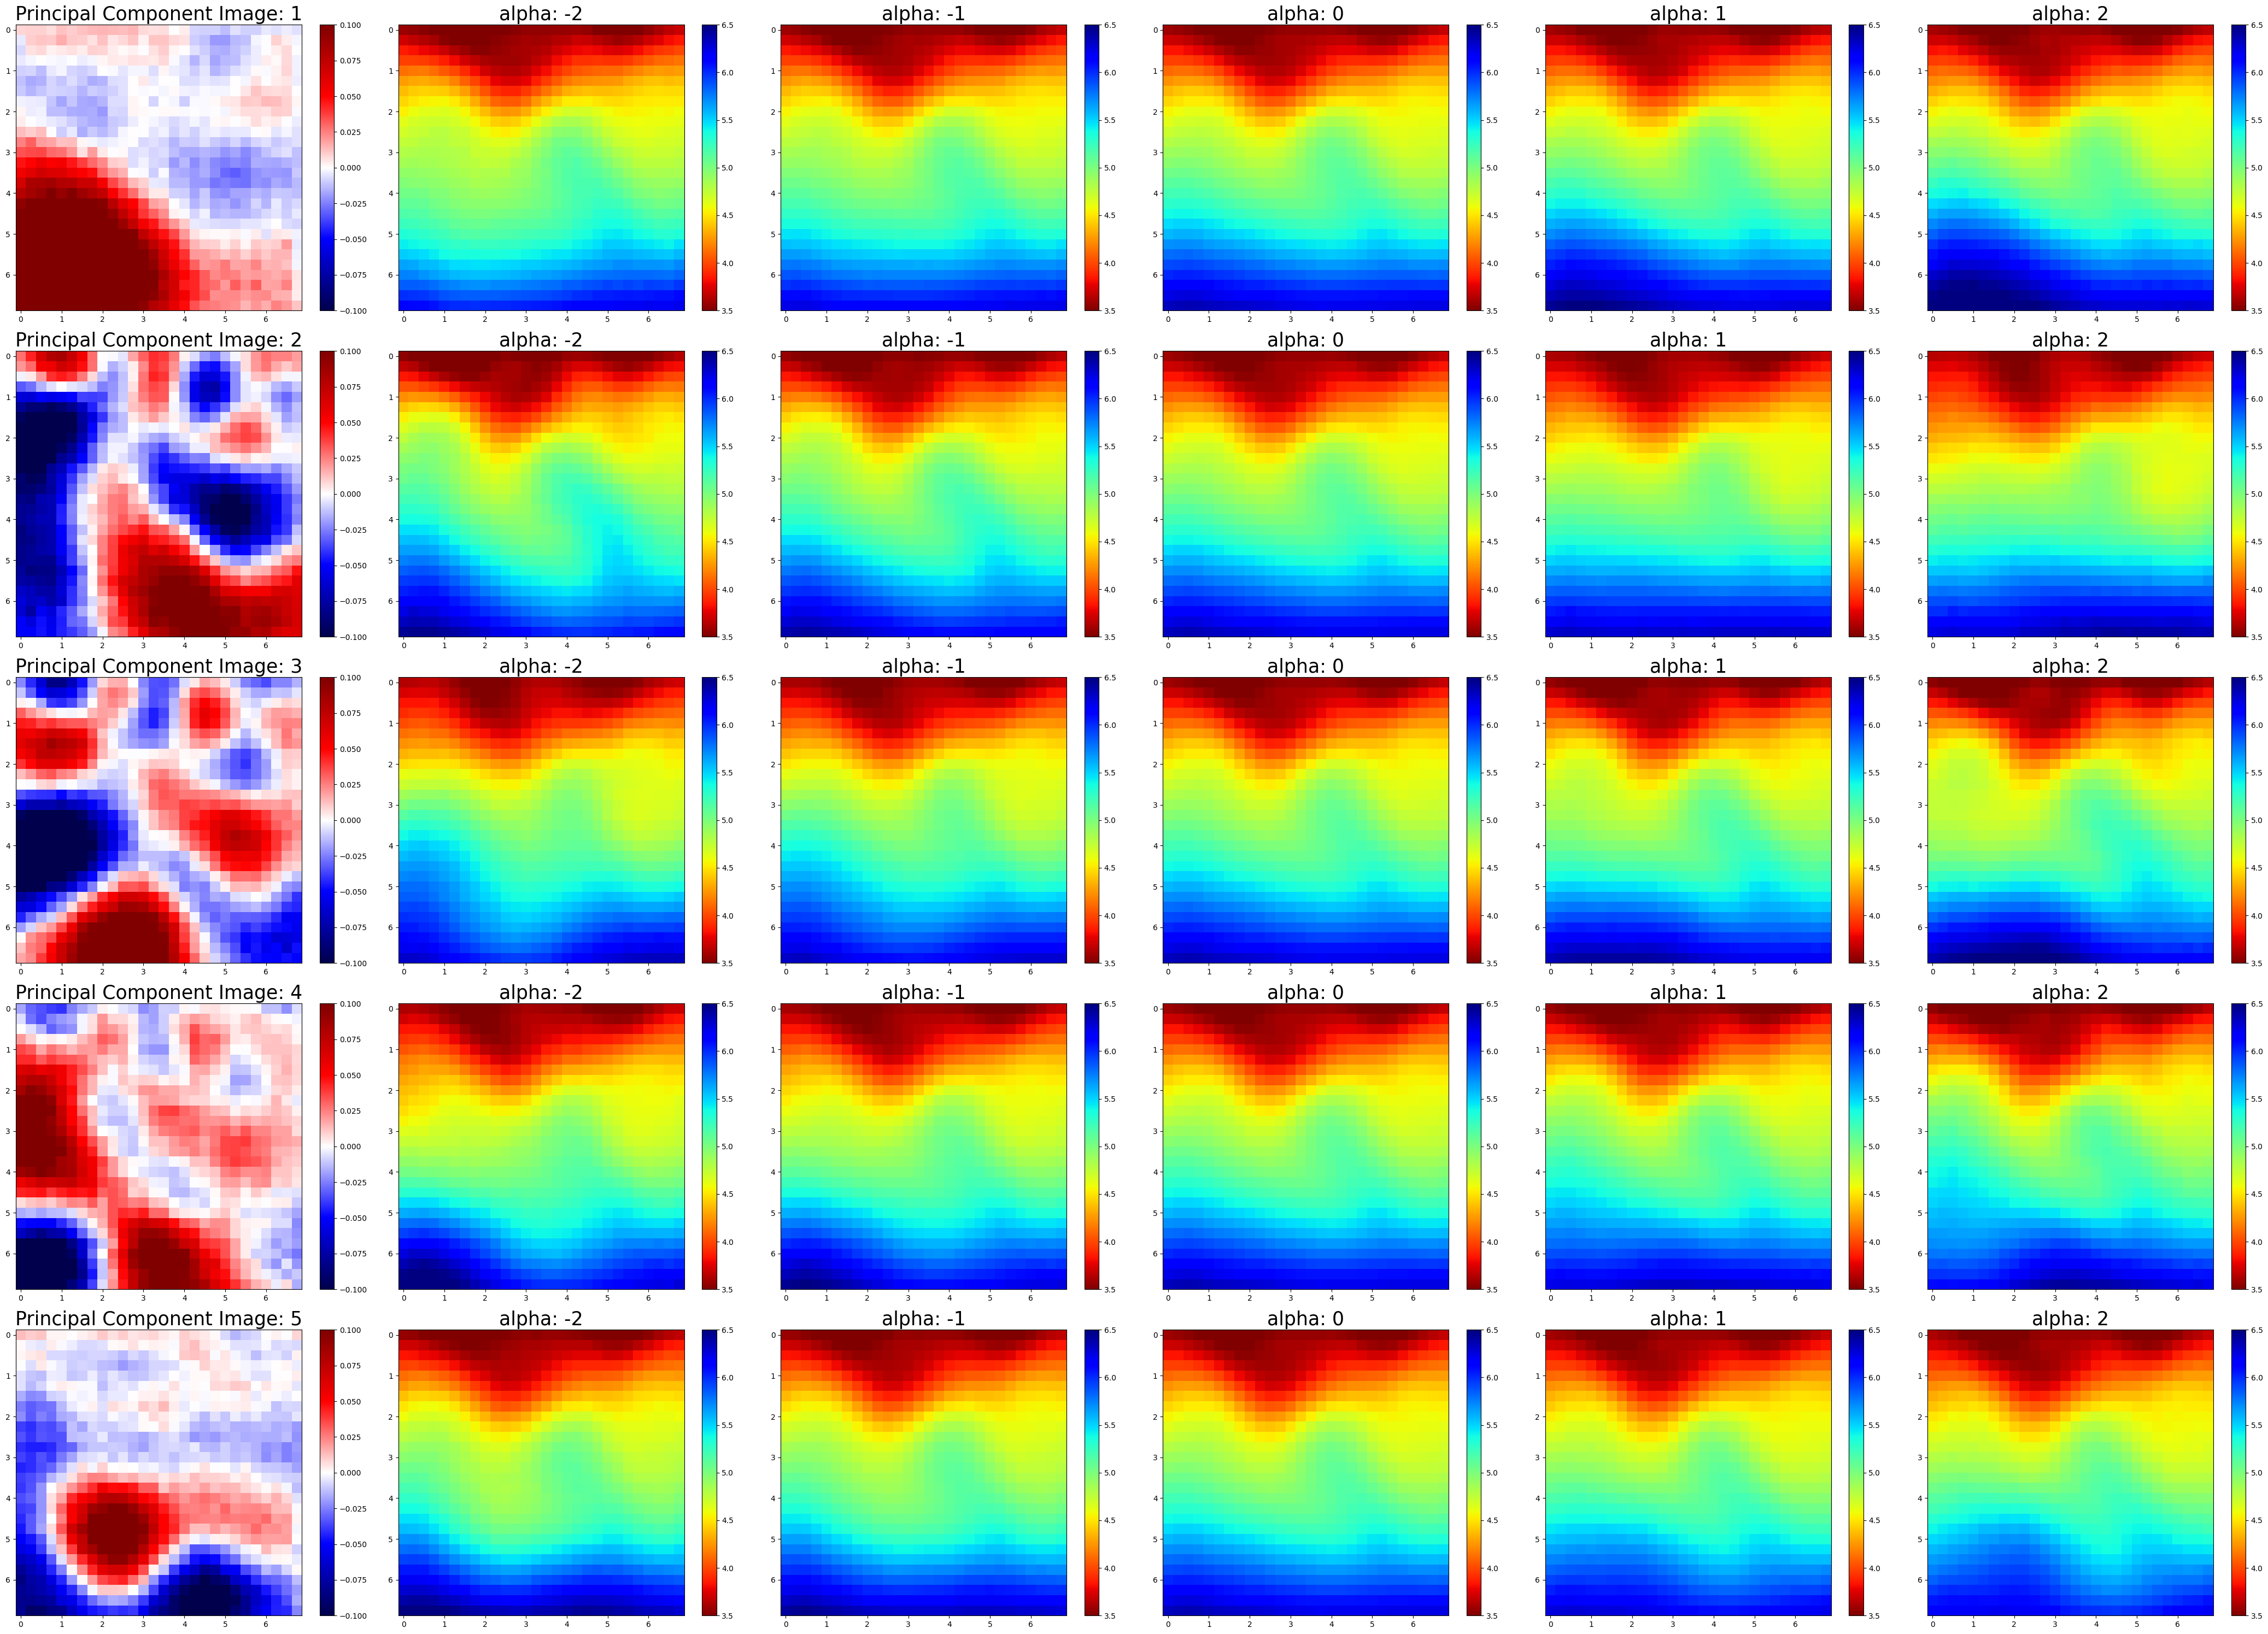

In [165]:
x_org, y_org = next(iter(test_loader))
with torch.no_grad():
    x_restored = restoration_net(y_org.to(device))
    w_mat = nppc_net(y_org.to(device), x_restored.to(device))
x_truth = x_org.to(device)
err = x_truth - x_restored
print("Error for this batch", + (err.pow(2).flatten(1).mean()).item())

batch = 20

# Plot the batch in a single row
fig, axes = plt.subplots(1, 2, figsize=(20, 10))


vmin_value = 3.5 
vmax_value = 6.5
truth_image = x_org[2, 0, :, :].cpu().numpy()

nx = truth_image.shape[0]
nz = truth_image.shape[1]

xcoor = np.arange(nx) * dx
zcoor = np.arange(nz) * dz
srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]

xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

ax = axes[0]
vim = ax.pcolormesh(xx, zz, truth_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
cbar = plt.colorbar(vim, ax=ax) 
ax.plot(srcx, srcz, '.', color='w', label='source', markersize=15)
ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=15)
ax.invert_yaxis()
ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
ax.set_ylabel('Depth (km)', fontsize=25)
ax.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.8)
ax.set_title(f"Ground Truth Image", fontsize=30)

restored_image = x_restored[2, 0, :, :].cpu().numpy()

nx = restored_image.shape[0]
nz = restored_image.shape[1]

xcoor = np.arange(nx) * dx
zcoor = np.arange(nz) * dz
srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]

xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

ax = axes[1]
vim = ax.pcolormesh(xx, zz, restored_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
cbar = plt.colorbar(vim, ax=ax) 
ax.plot(srcx, srcz, '.', color='w', label='source', markersize=15)
ax.plot(recx, recz, 'v', color='b', label='receiver', markersize=15)
ax.invert_yaxis()
ax.set_xlabel('Distance (km)', fontsize=25)  # Replace with your label for the x-axis
ax.set_ylabel('Depth (km)', fontsize=25)
ax.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.8)
ax.set_title(f"Restored Image", fontsize=30)

# Adjust layout
plt.tight_layout()
fig.savefig("plots/nppc_test", dpi=250)


fig, axes = plt.subplots(1, 5, figsize=(50, 10))

for i in range(5):
    ax = axes[i]

    w_image = w_mat[2, i, 0, :, :].detach().cpu().numpy()
    nx, nz = w_image.shape

    # Generate coordinates
    xcoor = np.arange(nx) * dx
    zcoor = np.arange(nz) * dz
    xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')

    # Plot the image using pcolormesh
    vim = ax.pcolormesh(xx, zz, w_image, cmap='seismic', vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(vim, ax=ax)
    ax.invert_yaxis()  # Invert the y-axis to match typical image coordinates
    ax.set_title(f"Principal Component Image: {i + 1}", fontsize=25)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(5, 6, figsize=(42, 30))

for i in range(5):
    for j in range(6):
        ax = axes[i, j]  # Select the current subplot

        # Select the specific image for this subplot
        if j == 0:  # For the first column, use the same image (first image)
            w_image = w_mat[2, i, 0, :, :].detach().cpu().numpy()  # First image of the batch
            nx, nz = w_image.shape

            # Generate coordinates
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
    
            # Plot the image using pcolormesh
            vim = ax.pcolormesh(xx, zz, w_image, cmap='seismic', vmin=-0.1, vmax=0.1)
            cbar = plt.colorbar(vim, ax=ax)
            ax.invert_yaxis()  # Invert the y-axis to match typical image coordinates
            ax.set_title(f"Principal Component Image: {i + 1}", fontsize=25)
        else:  # For the rest of the columns, use a different image  
            alpha = [-2, -1, 0, 1, 2]
            uncertainty_image =  x_restored[2, 0, :, :].cpu().numpy() + alpha[j-1] * w_mat[2, i, 0, :, :].detach().cpu().numpy()
            nx, nz = uncertainty_image.shape
            
            vmin_value = 3.5
            vmax_value = 6.5
        
            cmap = plt.get_cmap('RdBu_r')
            ax.set_aspect(1)
            xcoor = np.arange(nx) * dx
            zcoor = np.arange(nz) * dz
            srcx, srcz = xcoor[srcpos[:, 0]], zcoor[srcpos[:, 1]]
            recx, recz = xcoor[recpos[:, 0]], zcoor[recpos[:, 1]]
            xx, zz = np.meshgrid(xcoor, zcoor, indexing='ij')
            
            # Plot on the first axis (ax1)
            cmap = plt.get_cmap('RdBu_r')
            vim1 = ax.pcolormesh(xx, zz, uncertainty_image, cmap='jet_r', vmin=vmin_value, vmax=vmax_value)
            cbar1 = plt.colorbar(vim1, ax=ax)
            
            ax.invert_yaxis() 
            ax.set_title("alpha: " + str(alpha[j-1]), fontsize=25)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()
fig.savefig("plots/nppc_test_uncertainty_30", dpi=150)